## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [484]:
# Installing the libraries with the specified version.
#!pip install pandas==1.5.3 numpy==1.25.2 matplotlib==3.7.1 seaborn==0.13.1 scikit-learn==1.2.2 imbalanced-learn==0.10.1 xgboost==2.0.3 threadpoolctl==3.3.0 -q --user

**Note:** After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.

In [485]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)
from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# # Libraries to do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import GridSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# libraries for  imbalanced-learn Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline  

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier


# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To suppress warnings
import warnings

warnings.filterwarnings("ignore")

## Loading the dataset

**Read Training dataset**

In [486]:
# Code to read the training data
df = pd.read_csv('Train.csv') 

#### Make a copy of dataset (Train)

In [487]:
df_copy=df.copy()

**Read the Test dataset**

In [488]:
# Code to read the test data
df_test = pd.read_csv('Test.csv') 

#### Make a copy of dataset (Test)

In [489]:
df_test_copy=df_test.copy()

- *There are 2 dataset provided, one for train set (Train.csv) and another for test set(Test.csv).*

## Data Overview

- Observations
- Sanity checks

The initial steps to get an overview of any dataset is to:

- Viewing the first and last few rows of the dataset if they are loaded properly.
  
  - Checking the shape to get information about the number of rows and columns in the dataset
  - Checking datatypes of the dataset to ensure data is stored in the preferred format and the value of each feature is as expected.
  - Getting the statistical summary for the variables
  - Check for missing values
  - Check for duplicates

#### Displaying the first 5 rows of the dataset

In [490]:
#Train set
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


In [491]:
#Test set
df_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-0.613,-3.820,2.202,1.300,-1.185,-4.496,-1.836,4.723,1.206,-0.342,-5.123,1.017,4.819,3.269,-2.984,1.387,2.032,-0.512,-1.023,7.339,-2.242,0.155,2.054,-2.772,1.851,-1.789,-0.277,-1.255,-3.833,-1.505,1.587,2.291,-5.411,0.870,0.574,4.157,1.428,-10.511,0.455,-1.448,0
1,0.390,-0.512,0.527,-2.577,-1.017,2.235,-0.441,-4.406,-0.333,1.967,1.797,0.410,0.638,-1.390,-1.883,-5.018,-3.827,2.418,1.762,-3.242,-3.193,1.857,-1.708,0.633,-0.588,0.084,3.014,-0.182,0.224,0.865,-1.782,-2.475,2.494,0.315,2.059,0.684,-0.485,5.128,1.721,-1.488,0
2,-0.875,-0.641,4.084,-1.590,0.526,-1.958,-0.695,1.347,-1.732,0.466,-4.928,3.565,-0.449,-0.656,-0.167,-1.630,2.292,2.396,0.601,1.794,-2.120,0.482,-0.841,1.790,1.874,0.364,-0.169,-0.484,-2.119,-2.157,2.907,-1.319,-2.997,0.460,0.620,5.632,1.324,-1.752,1.808,1.676,0
3,0.238,1.459,4.015,2.534,1.197,-3.117,-0.924,0.269,1.322,0.702,-5.578,-0.851,2.591,0.767,-2.391,-2.342,0.572,-0.934,0.509,1.211,-3.260,0.105,-0.659,1.498,1.100,4.143,-0.248,-1.137,-5.356,-4.546,3.809,3.518,-3.074,-0.284,0.955,3.029,-1.367,-3.412,0.906,-2.451,0
4,5.828,2.768,-1.235,2.809,-1.642,-1.407,0.569,0.965,1.918,-2.775,-0.530,1.375,-0.651,-1.679,-0.379,-4.443,3.894,-0.608,2.945,0.367,-5.789,4.598,4.450,3.225,0.397,0.248,-2.362,1.079,-0.473,2.243,-3.591,1.774,-1.502,-2.227,4.777,-6.560,-0.806,-0.276,-3.858,-0.538,0


#### Displaying the last 5 rows of the dataset

In [492]:
#Train set
df.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
19995,-2.071,-1.088,-0.796,-3.012,-2.288,2.807,0.481,0.105,-0.587,-2.899,8.868,1.717,1.358,-1.777,0.710,4.945,-3.100,-1.199,-1.085,-0.365,3.131,-3.948,-3.578,-8.139,-1.937,-1.328,-0.403,-1.735,9.996,6.955,-3.938,-8.274,5.745,0.589,-0.650,-3.043,2.216,0.609,0.178,2.928,1
19996,2.890,2.483,5.644,0.937,-1.381,0.412,-1.593,-5.762,2.150,0.272,-2.095,-1.526,0.072,-3.540,-2.762,-10.632,-0.495,1.720,3.872,-1.210,-8.222,2.121,-5.492,1.452,1.450,3.685,1.077,-0.384,-0.839,-0.748,-1.089,-4.159,1.181,-0.742,5.369,-0.693,-1.669,3.660,0.820,-1.987,0
19997,-3.897,-3.942,-0.351,-2.417,1.108,-1.528,-3.520,2.055,-0.234,-0.358,-3.782,2.180,6.112,1.985,-8.330,-1.639,-0.915,5.672,-3.924,2.133,-4.502,2.777,5.728,1.620,-1.700,-0.042,-2.923,-2.760,-2.254,2.552,0.982,7.112,1.476,-3.954,1.856,5.029,2.083,-6.409,1.477,-0.874,0
19998,-3.187,-10.052,5.696,-4.370,-5.355,-1.873,-3.947,0.679,-2.389,5.457,1.583,3.571,9.227,2.554,-7.039,-0.994,-9.665,1.155,3.877,3.524,-7.015,-0.132,-3.446,-4.801,-0.876,-3.812,5.422,-3.732,0.609,5.256,1.915,0.403,3.164,3.752,8.530,8.451,0.204,-7.130,4.249,-6.112,0
19999,-2.687,1.961,6.137,2.600,2.657,-4.291,-2.344,0.974,-1.027,0.497,-9.589,3.177,1.055,-1.416,-4.669,-5.405,3.720,2.893,2.329,1.458,-6.429,1.818,0.806,7.786,0.331,5.257,-4.867,-0.819,-5.667,-2.861,4.674,6.621,-1.989,-1.349,3.952,5.450,-0.455,-2.202,1.678,-1.974,0


In [493]:
#Test set
df_test.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
4995,-5.120,1.635,1.251,4.036,3.291,-2.932,-1.329,1.754,-2.985,1.249,-6.878,3.715,-2.512,-1.395,-2.554,-2.197,4.772,2.403,3.792,0.487,-2.028,1.778,3.668,11.375,-1.977,2.252,-7.319,1.907,-3.734,-0.012,2.120,9.979,0.063,0.217,3.036,2.109,-0.557,1.939,0.513,-2.694,0
4996,-5.172,1.172,1.579,1.220,2.530,-0.669,-2.618,-2.001,0.634,-0.579,-3.671,0.460,3.321,-1.075,-7.113,-4.356,-0.001,3.698,-0.846,-0.222,-3.645,0.736,0.926,3.278,-2.277,4.458,-4.543,-1.348,-1.779,0.352,-0.214,4.424,2.604,-2.152,0.917,2.157,0.467,0.470,2.197,-2.377,0
4997,-1.114,-0.404,-1.765,-5.879,3.572,3.711,-2.483,-0.308,-0.922,-2.999,-0.112,-1.977,-1.623,-0.945,-2.735,-0.813,0.610,8.149,-9.199,-3.872,-0.296,1.468,2.884,2.792,-1.136,1.198,-4.342,-2.869,4.124,4.197,3.471,3.792,7.482,-10.061,-0.387,1.849,1.818,-1.246,-1.261,7.475,0
4998,-1.703,0.615,6.221,-0.104,0.956,-3.279,-1.634,-0.104,1.388,-1.066,-7.970,2.262,3.134,-0.486,-3.498,-4.562,3.136,2.536,-0.792,4.398,-4.073,-0.038,-2.371,-1.542,2.908,3.215,-0.169,-1.541,-4.724,-5.525,1.668,-4.100,-5.949,0.550,-1.574,6.824,2.139,-4.036,3.436,0.579,0
4999,-0.604,0.960,-0.721,8.230,-1.816,-2.276,-2.575,-1.041,4.130,-2.731,-3.292,-1.674,0.465,-1.646,-5.263,-7.988,6.480,0.226,4.963,6.752,-6.306,3.271,1.897,3.271,-0.637,-0.925,-6.759,2.990,-0.814,3.499,-8.435,2.370,-1.062,0.791,4.952,-7.441,-0.070,-0.918,-2.291,-5.363,0


#### Displaying random 5 rows of the dataset

`sample(n=5) ` function will display any randomly selected 5 rows of the dataset here, instead of fetching first 5 or last 5 rows using head() and tail() functions respectively.

In [494]:
#Train set
df.sample(n=5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
12765,2.021,-0.645,-0.682,6.518,-1.749,-3.570,-2.406,0.332,5.186,-1.582,-5.554,-2.866,3.552,1.539,-5.580,-6.918,4.716,-0.158,1.944,7.242,-6.687,4.179,3.868,1.104,1.135,-1.097,-2.660,1.510,-5.473,-0.671,-5.146,4.074,-4.977,-0.124,3.147,-3.912,-0.338,-5.756,-1.935,-5.377,1
19853,-0.334,-1.607,0.139,-5.395,-0.125,1.540,-1.804,-1.697,1.241,-2.334,-0.468,1.583,3.807,-0.554,-4.925,-4.156,-0.919,6.097,-4.818,0.201,-3.788,2.290,1.330,-3.418,0.453,-0.030,0.793,-2.607,0.992,1.333,-2.222,-4.515,0.784,-3.839,-1.039,3.035,3.231,-1.647,1.820,3.236,0
6604,-0.708,-3.334,1.840,0.213,-1.031,-2.413,-2.089,3.371,-0.306,0.584,-0.712,0.265,4.615,2.118,-3.631,2.026,-2.257,-0.628,-0.436,2.236,-2.970,-0.157,1.443,-0.686,-0.876,0.022,-1.079,-2.476,-0.197,2.842,3.258,6.031,1.765,-1.429,4.366,2.113,-0.574,-7.663,-0.484,-2.102,0
10162,2.820,0.702,9.223,-0.745,-2.781,-2.195,-0.512,-3.374,0.315,2.236,-3.626,2.915,2.147,-2.456,-1.044,-7.926,-1.850,-0.350,6.134,0.717,-7.972,0.700,-7.258,-1.490,3.251,2.964,5.104,-1.143,-3.102,-3.939,1.455,-7.777,-3.742,3.607,4.703,4.848,-0.893,1.058,3.325,-2.448,0
17625,-0.101,-1.140,4.889,5.098,-3.319,-4.420,-2.191,0.705,2.048,-0.289,-4.083,1.889,3.574,-0.753,-4.308,-5.612,2.645,-1.555,6.466,7.044,-7.497,1.276,-1.761,-0.336,1.067,-0.105,-1.887,0.516,-2.093,1.035,-3.287,-0.826,-3.458,3.531,6.137,-0.606,-0.089,-4.462,0.408,-5.461,0


In [495]:
#Test set
df_test.sample(n=5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
542,-2.241,0.721,1.455,0.991,-1.726,-2.099,1.559,0.172,-0.583,-0.153,-0.442,6.612,1.776,-1.450,-0.075,-0.566,1.287,-1.648,5.255,2.883,-0.456,-0.443,-0.856,-2.462,0.273,-0.501,1.028,1.353,-0.897,-1.550,-5.078,-7.159,-5.301,6.559,-1.588,0.964,2.139,2.682,2.982,-2.212,0
4163,0.697,7.667,3.343,-1.553,4.190,-1.345,-0.612,0.672,2.605,-8.171,-4.208,3.385,3.817,-3.789,-5.385,-3.454,4.386,4.163,-6.598,-2.396,-5.427,1.111,2.958,-0.333,-0.186,10.436,-6.796,-4.789,0.685,-1.030,1.523,-1.137,0.491,-9.069,-1.640,0.184,2.598,-2.974,-0.271,6.363,1
380,-3.919,0.532,1.257,-1.075,2.444,-0.876,-3.732,-1.172,1.399,-2.069,-3.413,1.418,7.420,-0.597,-11.117,-5.440,-1.785,5.850,-3.637,-1.254,-7.500,2.841,4.304,2.551,-3.116,5.838,-5.032,-3.999,-1.663,2.522,0.316,7.075,4.413,-6.256,2.931,2.591,0.999,-3.067,1.676,-1.726,0
2326,-4.749,-5.724,4.006,-0.710,-0.044,-1.431,-4.974,-0.895,-0.382,3.227,-5.531,-1.408,4.003,1.783,-7.342,-4.830,-2.043,4.894,-0.433,3.784,-5.258,1.050,-1.349,2.188,-0.111,-0.898,-0.700,-1.611,-3.194,0.868,2.939,5.369,1.867,-0.714,4.261,7.405,0.189,-5.153,2.935,-3.627,0
1351,-4.442,-2.568,-2.504,-1.326,-0.045,0.502,-2.954,-2.890,2.071,-1.084,-2.619,1.927,5.138,0.037,-9.037,-7.283,0.490,6.895,-1.619,3.071,-4.877,4.159,4.303,-0.030,-1.446,-1.566,-1.734,-0.075,-2.177,1.706,-7.395,-0.602,-0.502,-0.773,-0.808,1.607,3.427,0.449,2.913,-2.389,0


#### Checking the shape of dataset

In [496]:
#Train set
df.shape
print('The dataset ReneWind contains', df.shape[0], 'rows and', df.shape[1],' columns in train dataset.')

The dataset ReneWind contains 20000 rows and 41  columns in train dataset.


In [497]:
#Test set
df_test.shape
print('The dataset ReneWind contains', df_test.shape[0], 'rows and', df_test.shape[1],' columns in test dataset.')

The dataset ReneWind contains 5000 rows and 41  columns in test dataset.


#### Checking the data types of the columns

In [498]:
#Train set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

In [499]:
#Test set
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

- *There are `41 columns V1-V40, V0-V39 (dtype=float) predictors` while `Target(dtype=int)` categorical column, all are stored as numerical value*.
  
- *There are `20,000 non-null` (i.e. no missing values )value present in `train set` and `5000 non-null` value in `Test set` for all columns `except for V1 & V2`.*
- *Column name here are the `ciphered value` so we cannot infer whats each column means as no data description is provided.* 

#### Statistical summary of the dataset

- *The `describe()` function will display the summary statistics of the numerical data. To view summary statistics of both numerical and categorical data we use describe(include='all')*.

In [500]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,19982.000,-0.272,3.442,-11.876,-2.737,-0.748,1.840,15.493
V2,19982.000,0.440,3.151,-12.320,-1.641,0.472,2.544,13.089
V3,20000.000,2.485,3.389,-10.708,0.207,2.256,4.566,17.091
V4,20000.000,-0.083,3.432,-15.082,-2.348,-0.135,2.131,13.236
V5,20000.000,-0.054,2.105,-8.603,-1.536,-0.102,1.340,8.134
V6,20000.000,-0.995,2.041,-10.227,-2.347,-1.001,0.380,6.976
V7,20000.000,-0.879,1.762,-7.950,-2.031,-0.917,0.224,8.006
V8,20000.000,-0.548,3.296,-15.658,-2.643,-0.389,1.723,11.679
V9,20000.000,-0.017,2.161,-8.596,-1.495,-0.068,1.409,8.138
V10,20000.000,-0.013,2.193,-9.854,-1.411,0.101,1.477,8.108


**observation**

- *Since all the columns are numerical value and there are no specific description about columns, not much can be inferred except for range.*

- *The `standard  deviation ranges from (1.7 to 5.5)` for all the columns except target variable.It's `highest for V32` indicating data are more spread out*.
- *The `minimum values are negative` in nature while maximum contains only positives value.*
  
- *Except for few variables `50% of IQR range` contains `negative values or smaller positive number.`*
  
- *Both `Mean and median` for almost all columns are `small positive number or negative values`.*

- *Target columns contains 0 or 1 value.*

#### Check for duplicate data

In [501]:
df.duplicated().sum()

0

- *There are `no duplicate data present` in the row.*

#### Check for null/missing value

In [502]:
df.isnull().sum()

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

- *Missing values are present for 2 columns `V1(count=18) and V2 (count=18)`. However we will not treat them now as it will lead to `data leakage problem`*

## Exploratory Data Analysis (EDA)

### Univariate analysis

### Plotting histograms and boxplots for all the variables

In [503]:
#create a function to plot histogram and box plot for numericals columns 
def univariate_analysis_for_numCols(df,column_name, figsize=(15, 10),kde=True):
    """
    Boxplot and histogram combined

    df: dataframe
    column_name: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    
    """
       
        # creating the 2 subplots one for histogram and another for boxplot
          
    f, (ax_hist, ax_box) = plt.subplots(
        nrows=2,                                          # Number of rows of the subplot grid= 2(one for hist and another for box plot)
        sharex=True,                                      # both the subplots will share the same x-axis for same alignment
        gridspec_kw={"height_ratios": (0.75, 0.25)},      # height ratios to ensure histogram (more detailed) get more space compared to box plot. 
        figsize=figsize,
    )  
   
    #create a histplot on first subplot
    ax_hist.set_title(f'Histogram for {column_name}')
    sns.histplot(data = df , x = column_name , ax = ax_hist, color = 'blue' , kde = kde) 
    ax_hist.axvline(df[column_name].mean() , color = 'green', linestyle='--')
    ax_hist.axvline(df[column_name].median() , color = 'black')
   # plt.show()                  
    #create boxplot on second subplot
    sns.boxplot(data = df , x = column_name , ax = ax_box, color = 'orange',showmeans = True)
    ax_box.set_title(f'Boxplot for {column_name}')
    plt.show()   

### Plotting all the features at one go

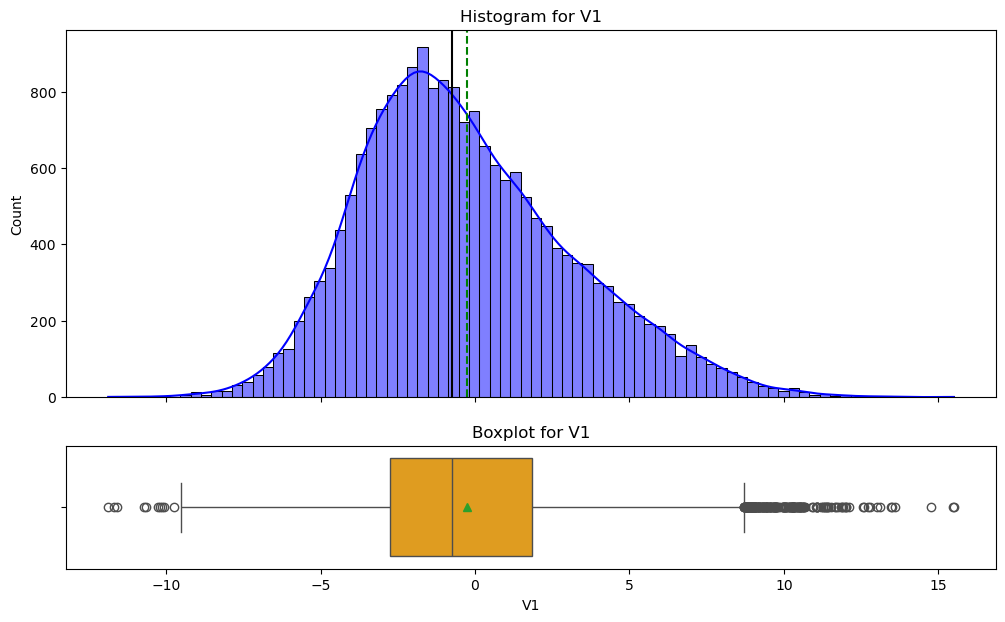

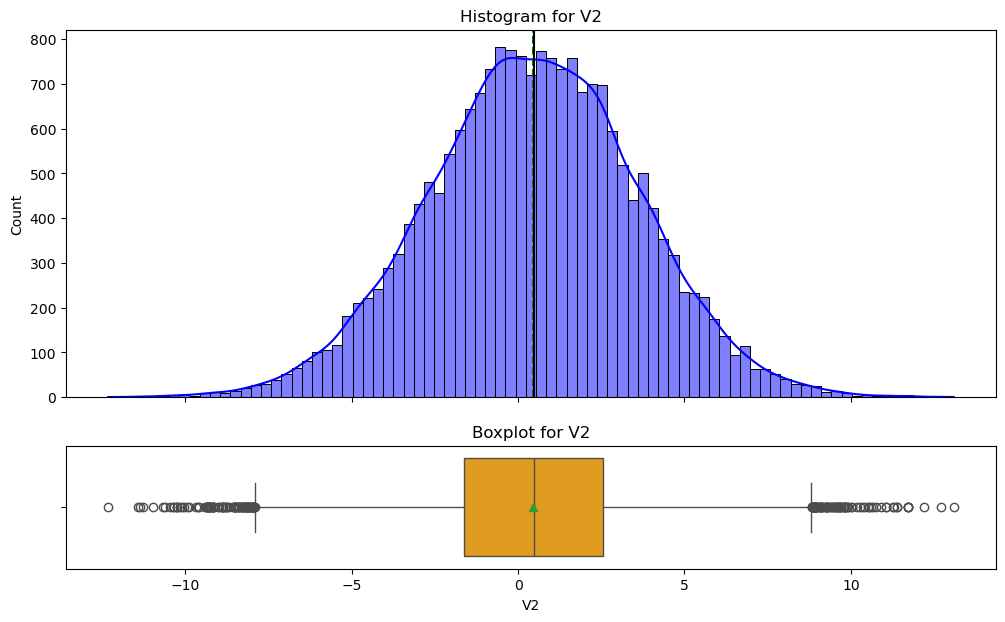

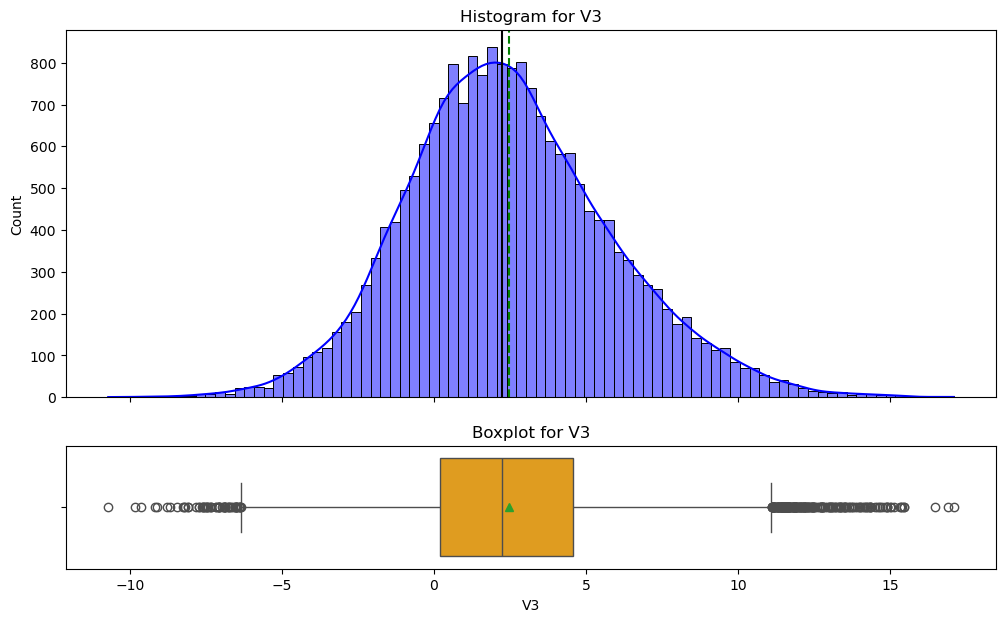

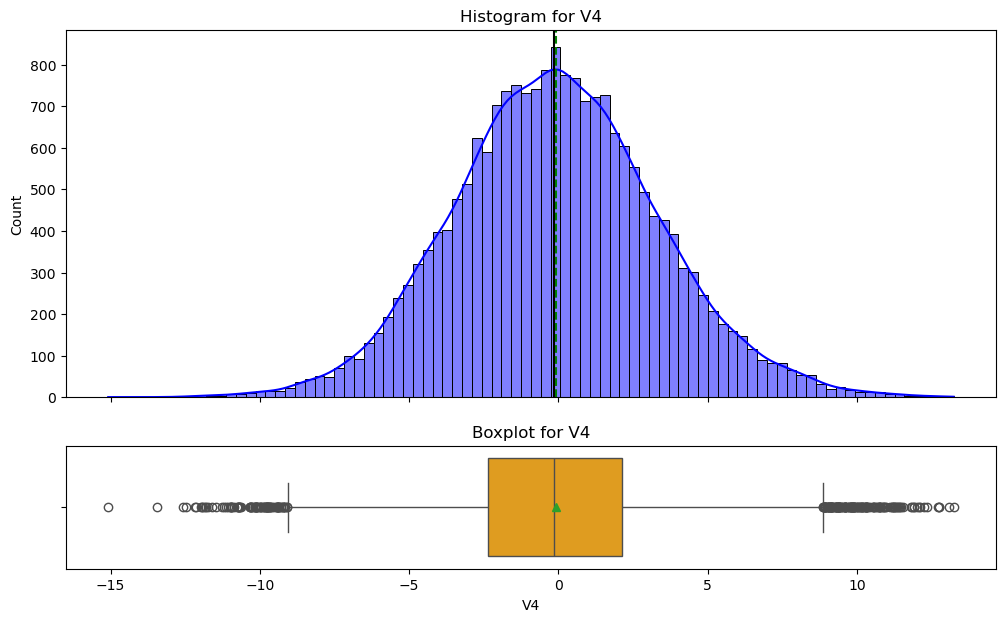

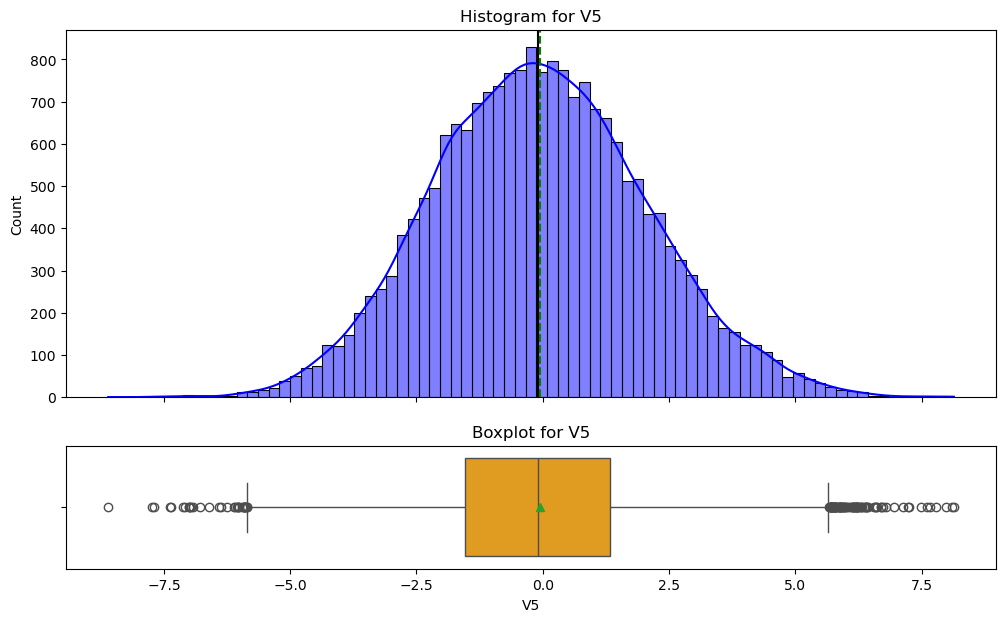

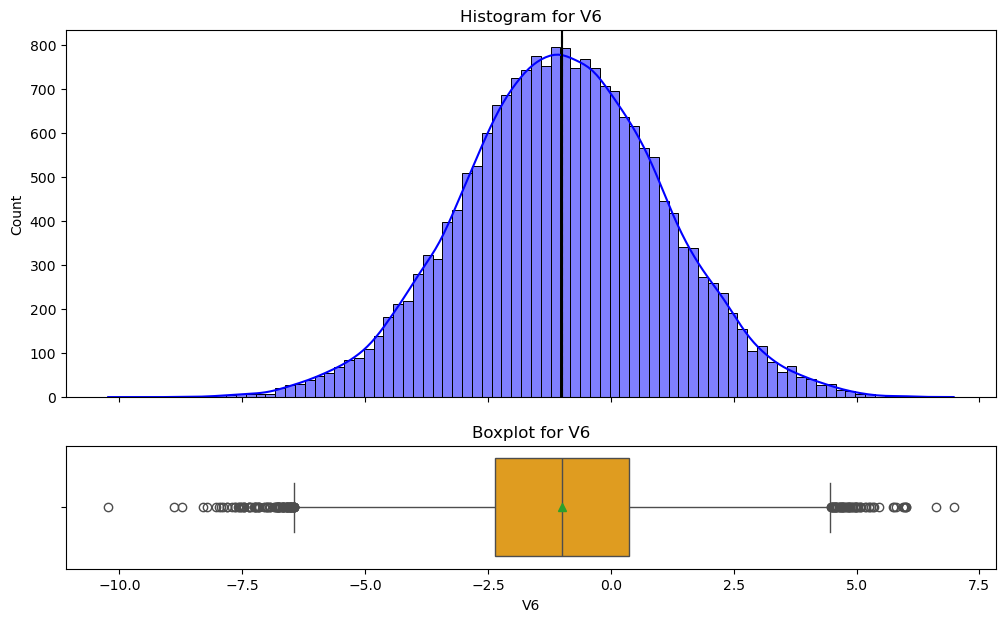

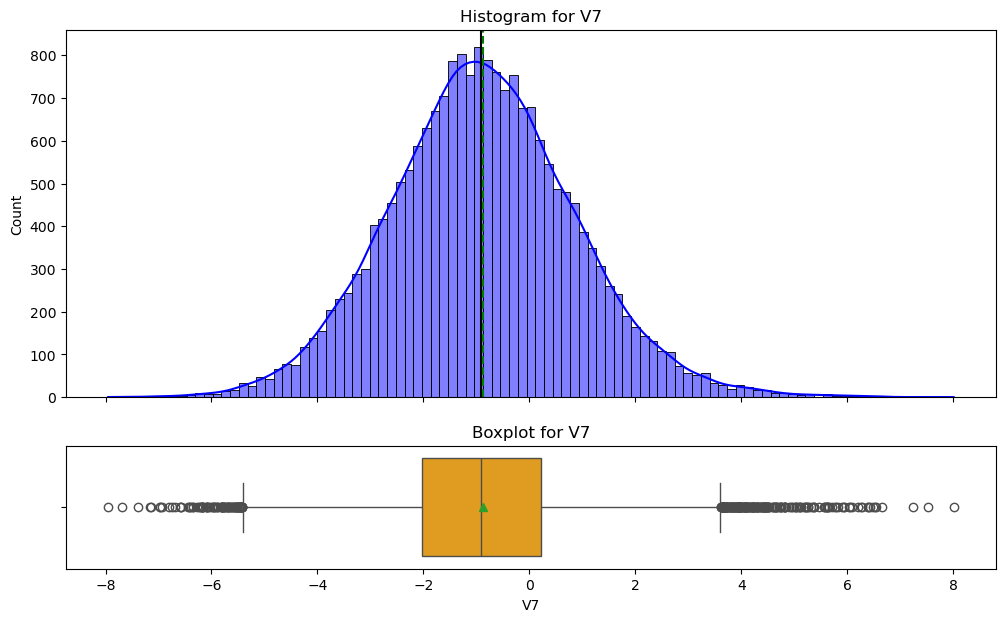

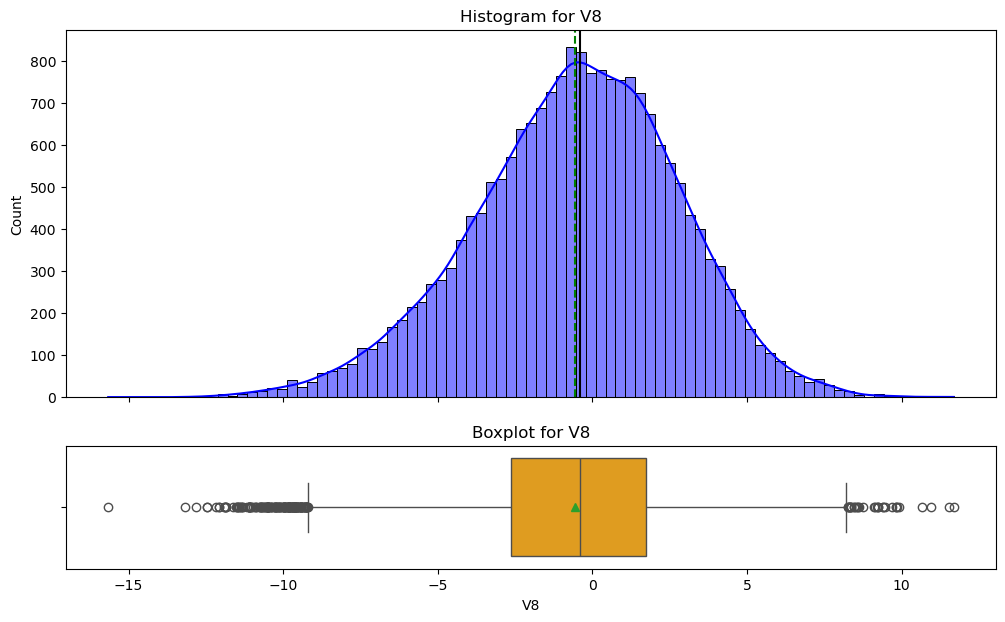

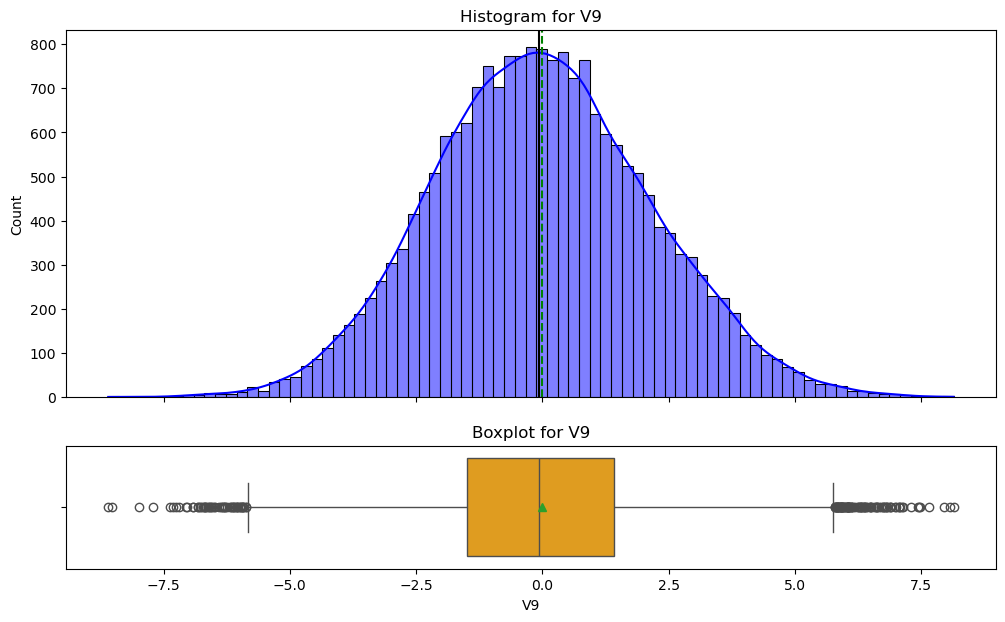

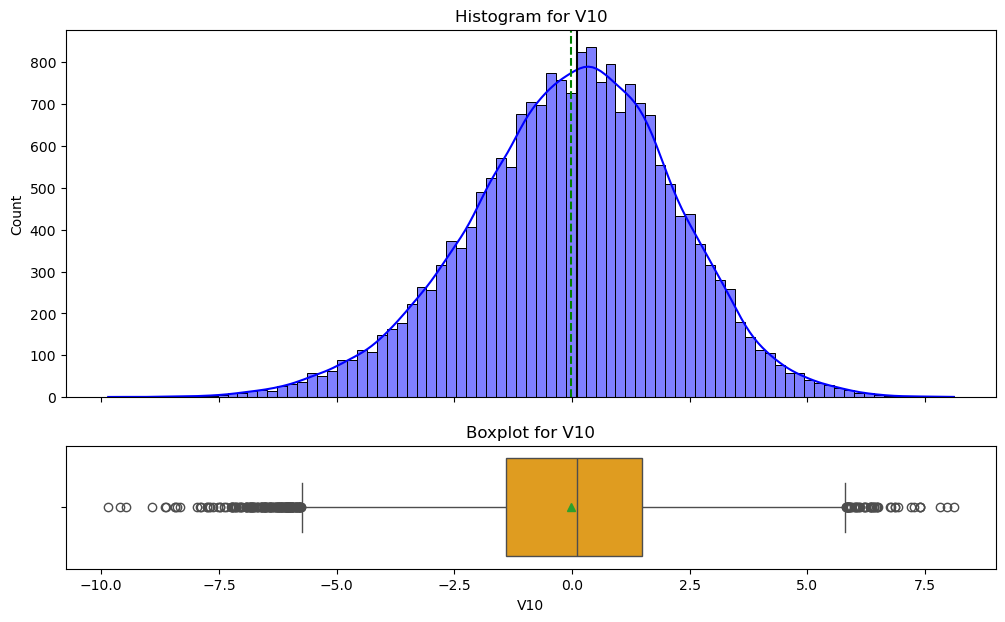

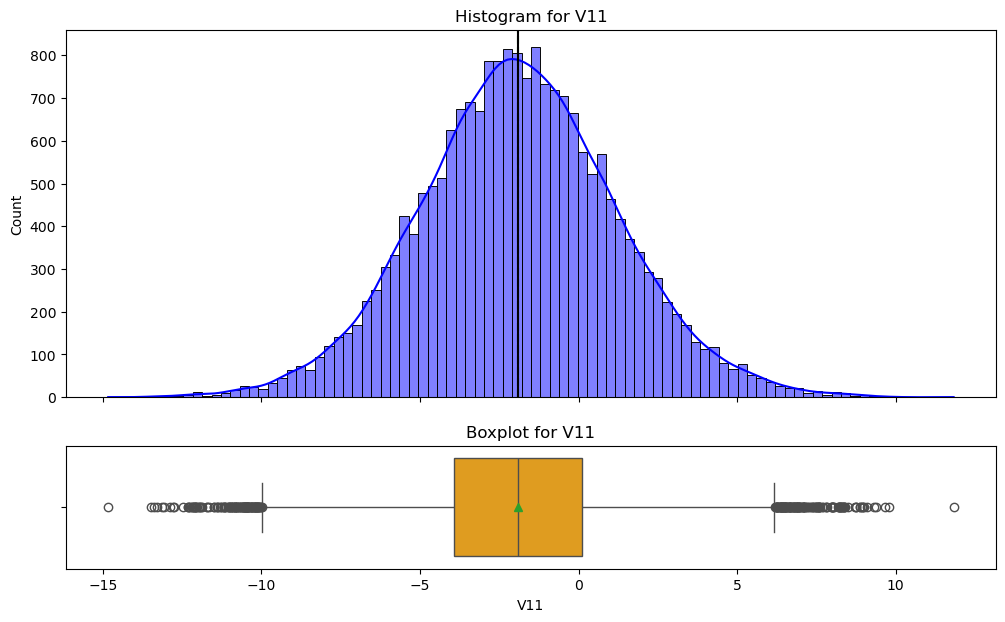

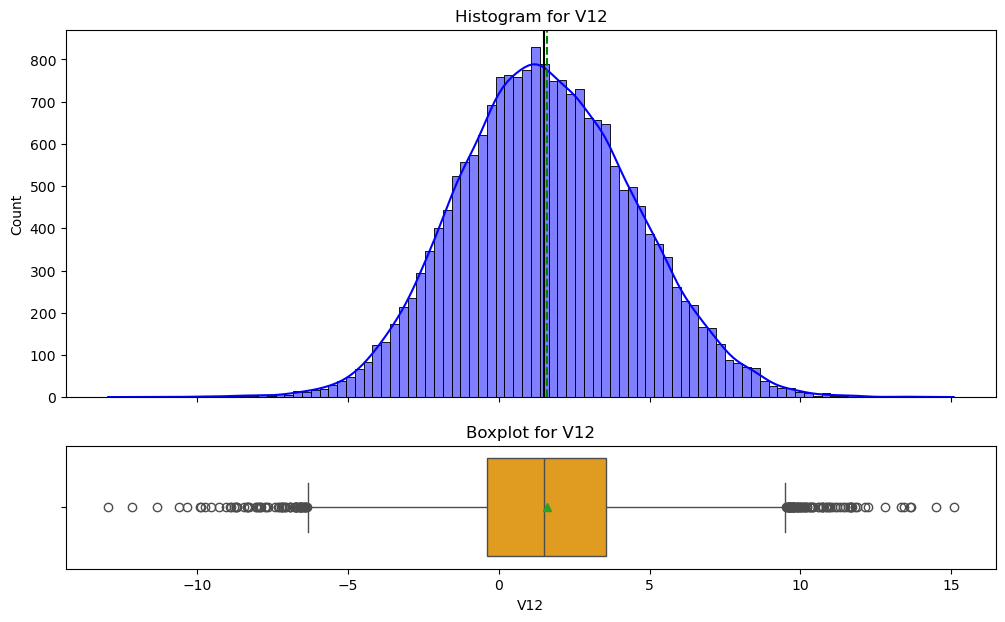

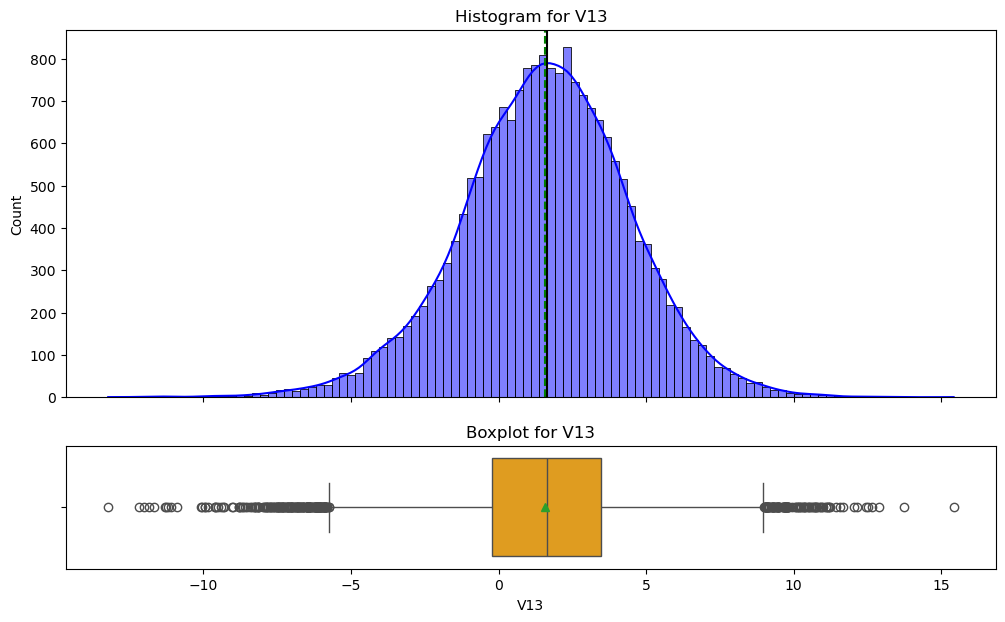

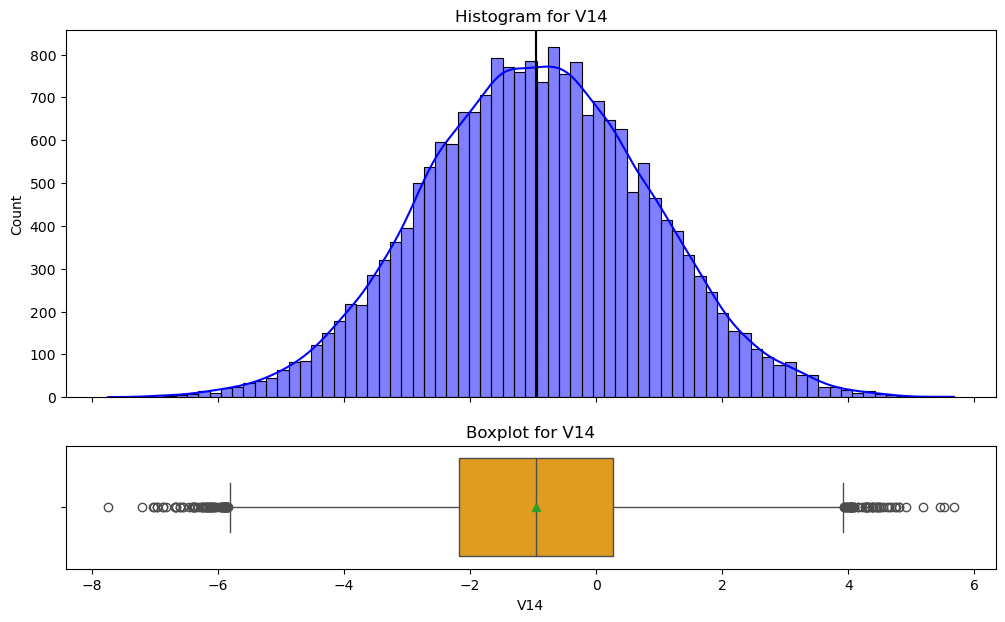

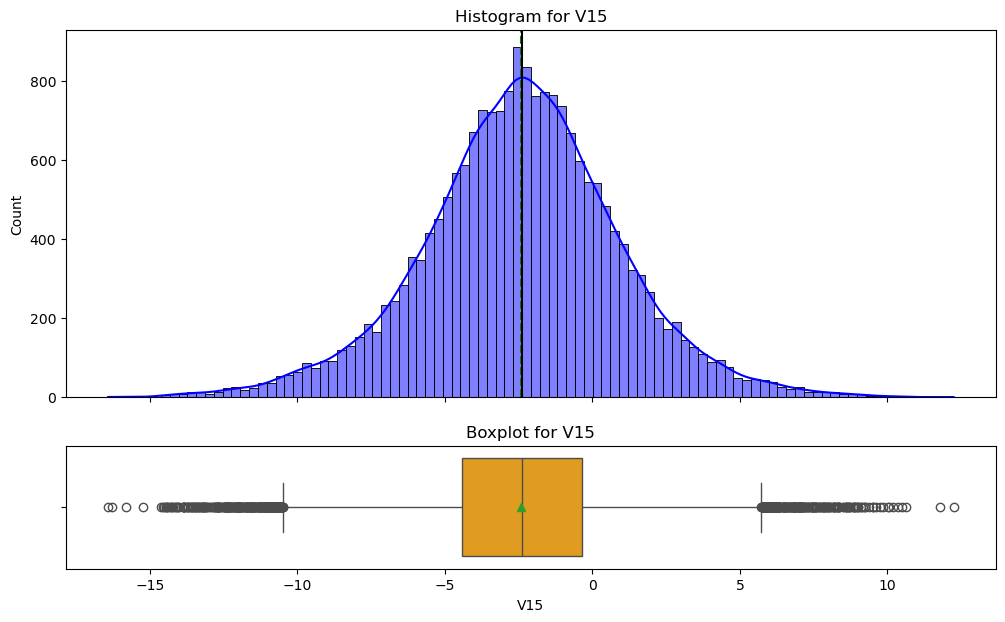

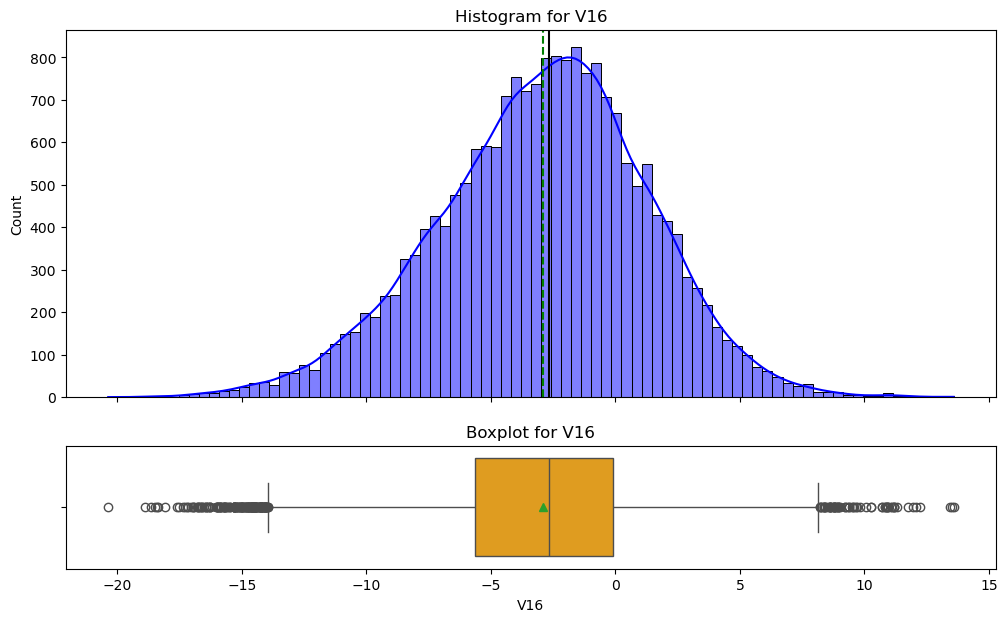

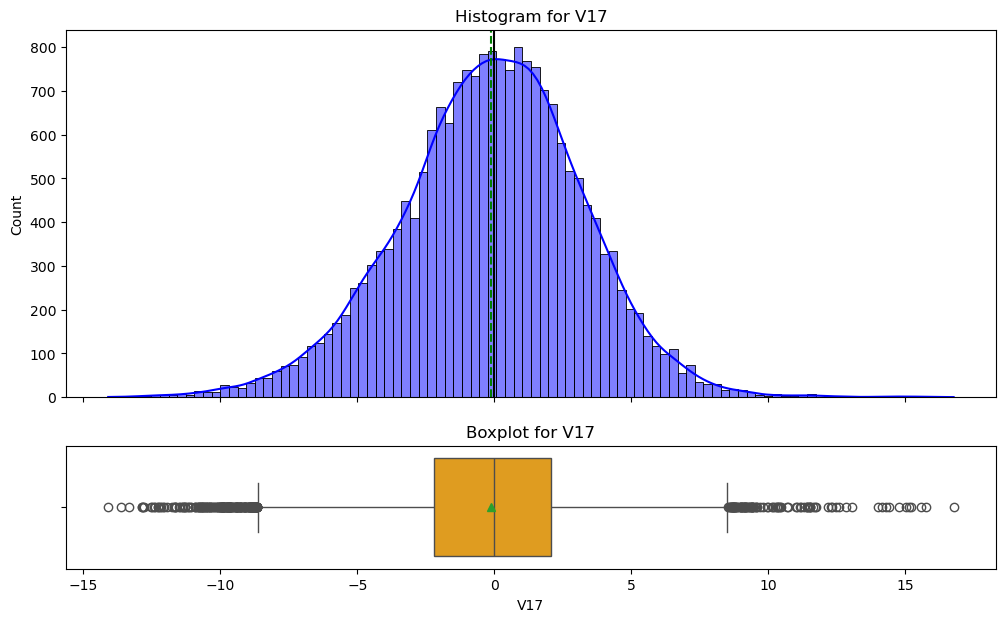

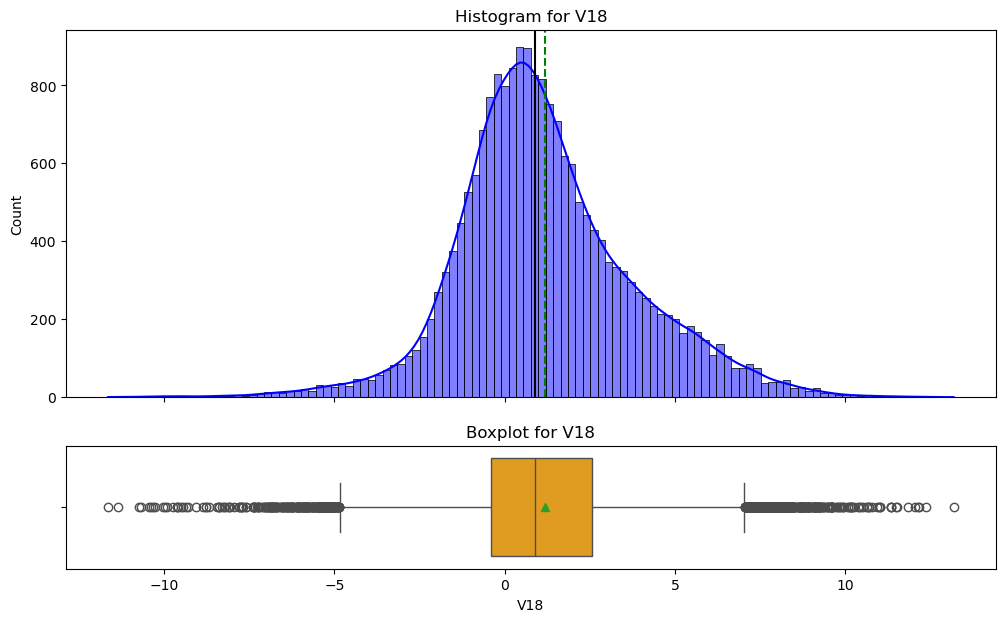

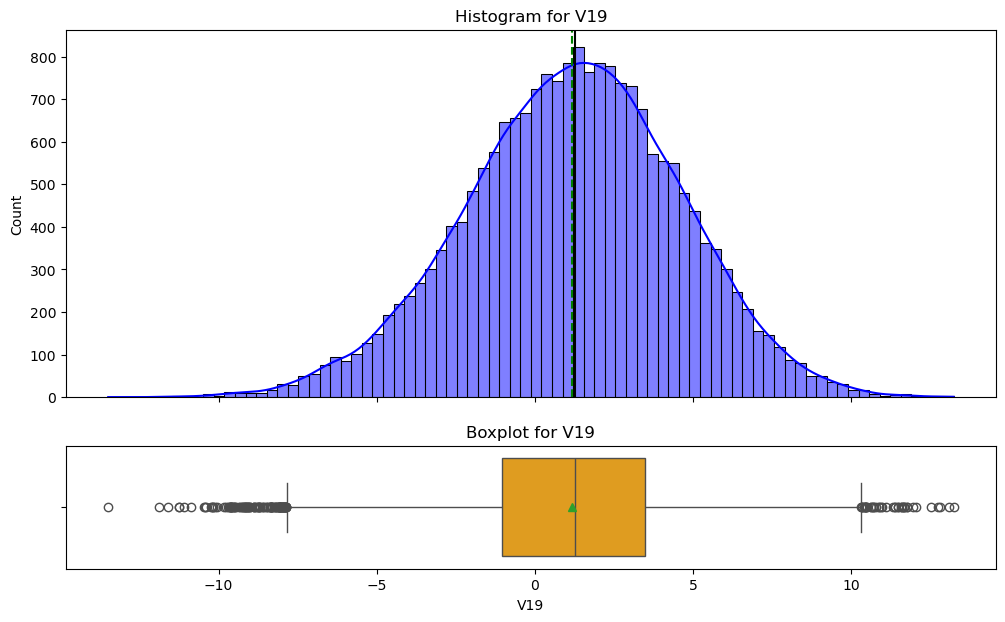

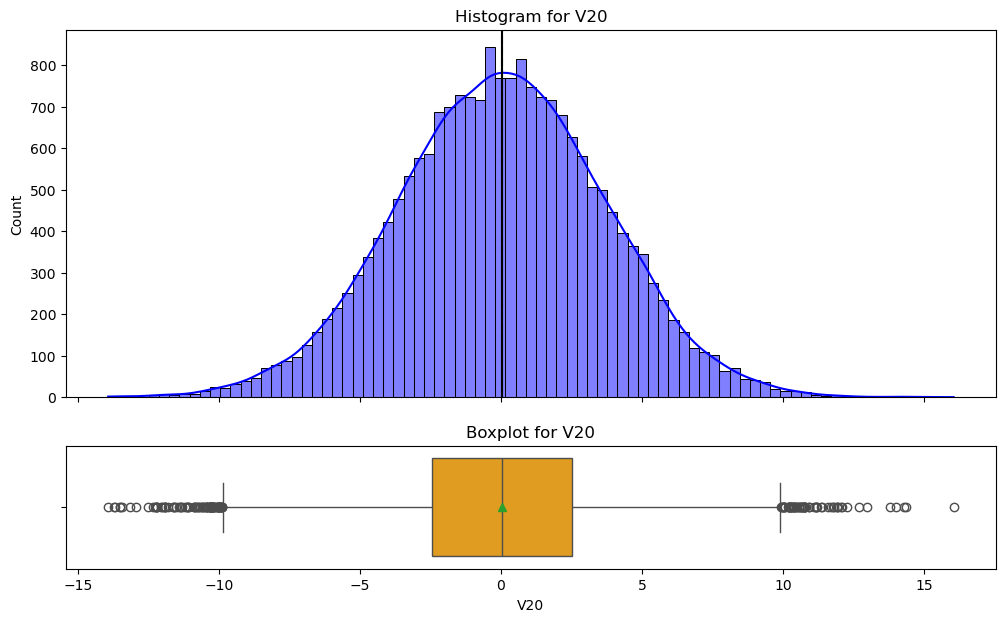

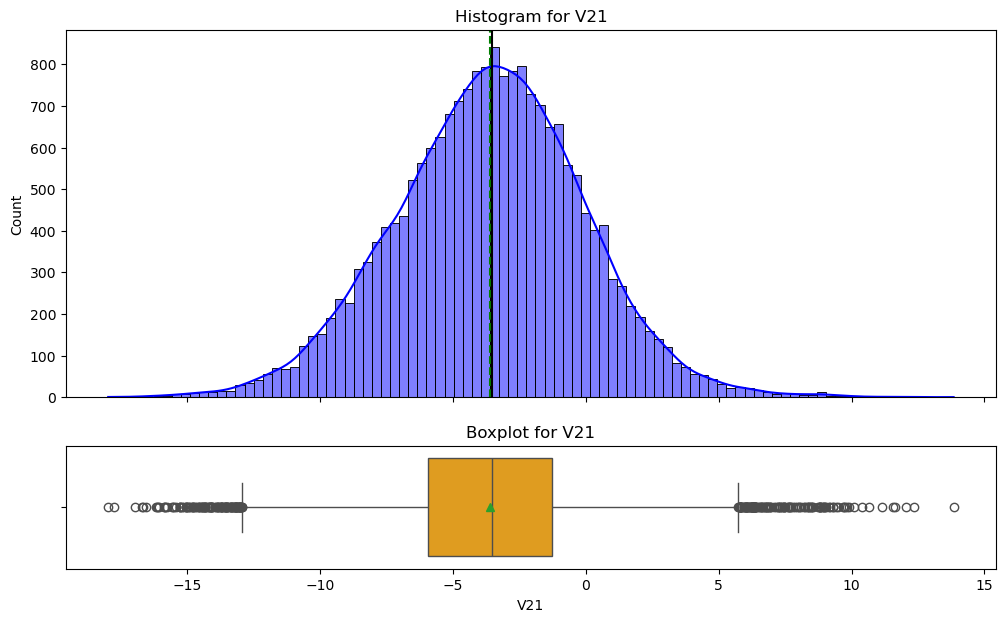

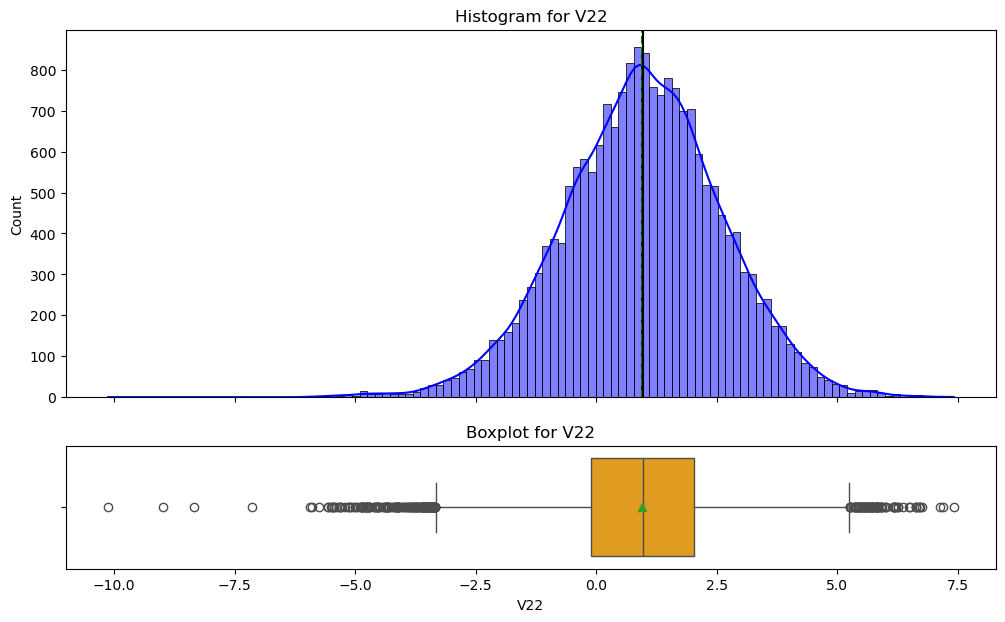

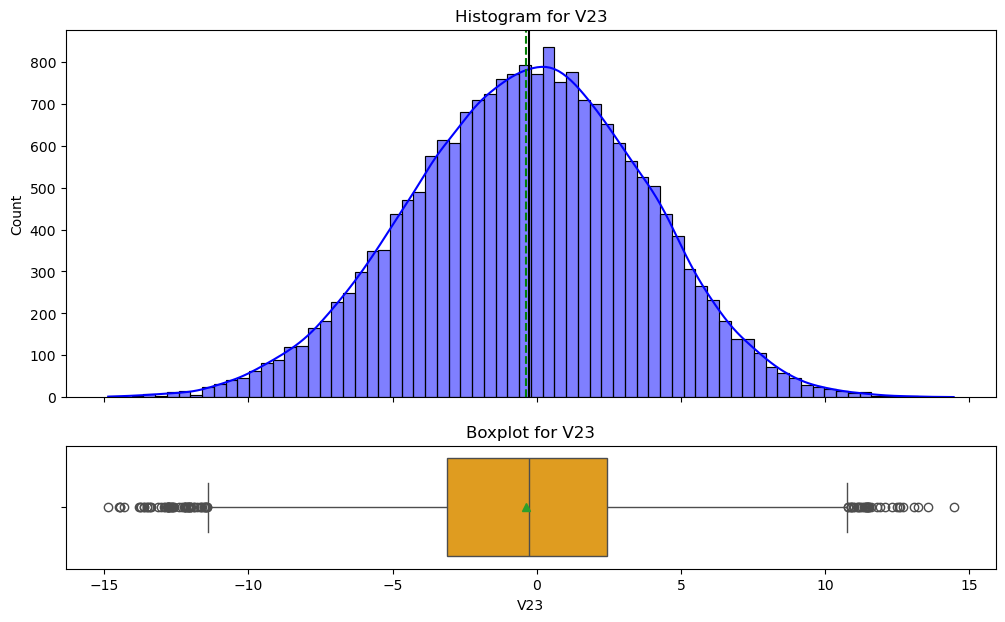

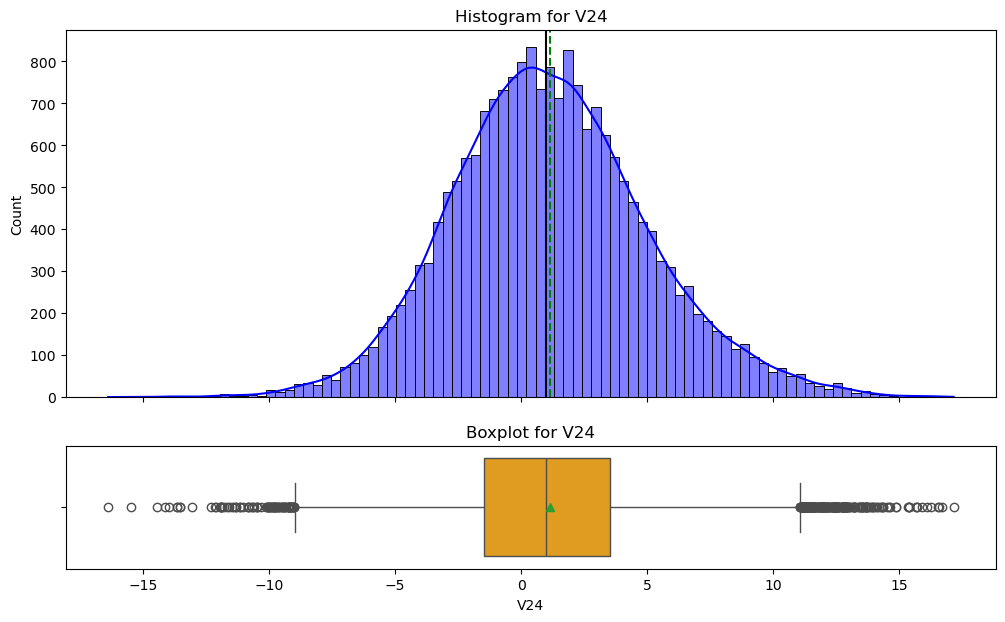

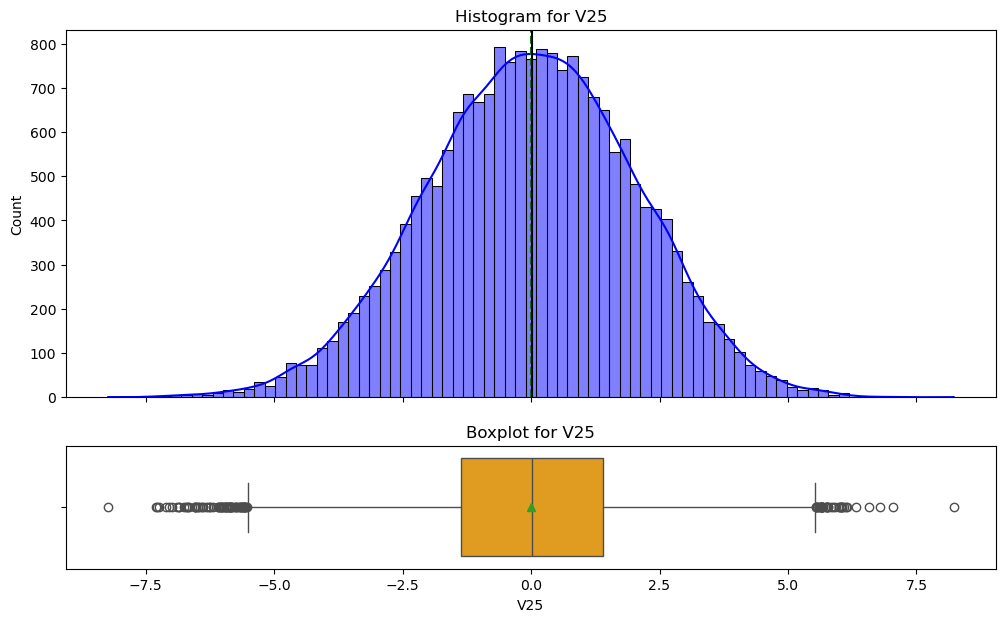

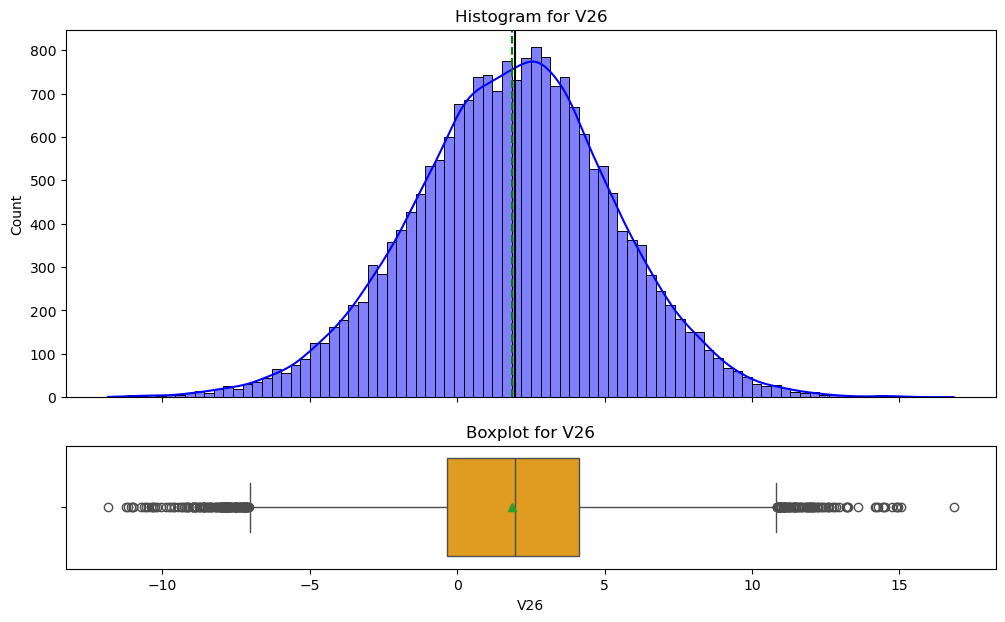

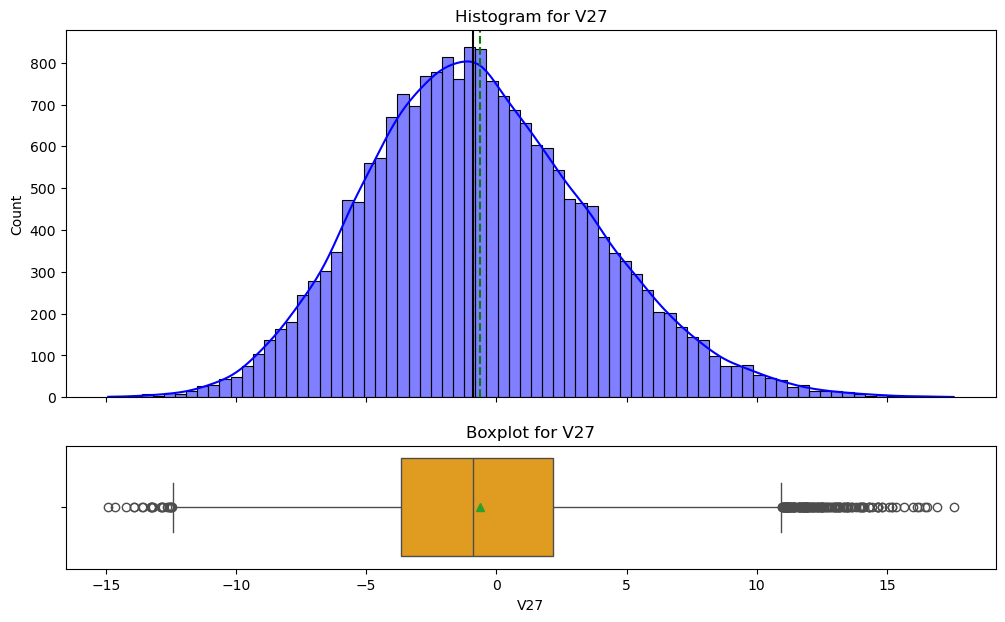

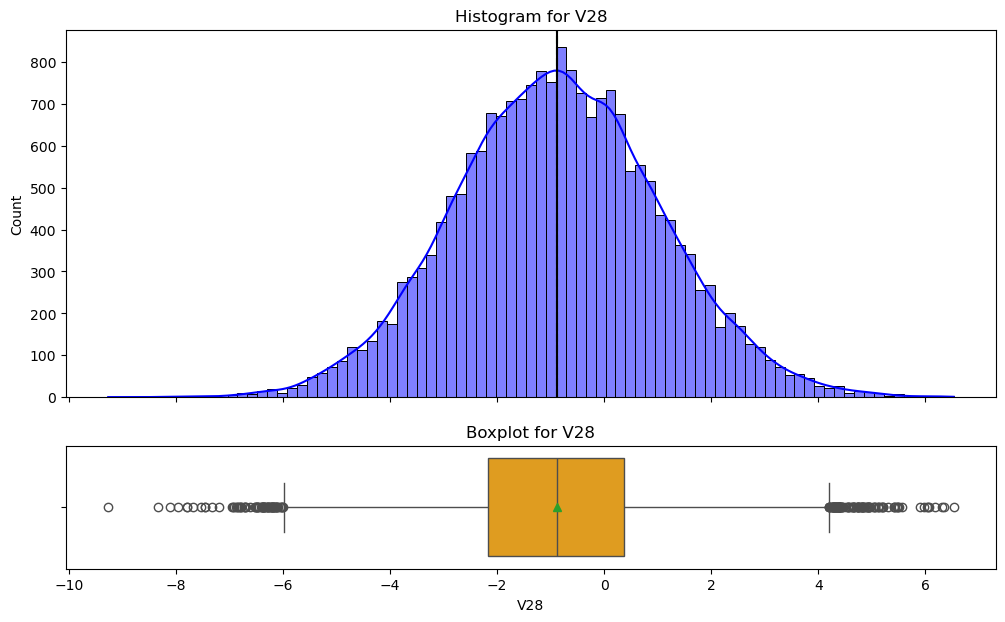

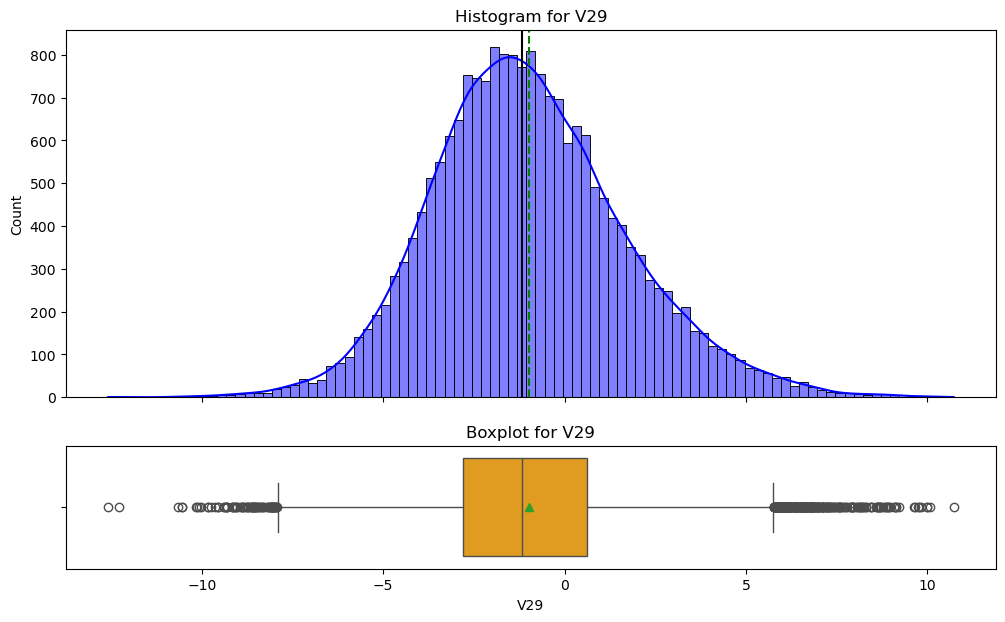

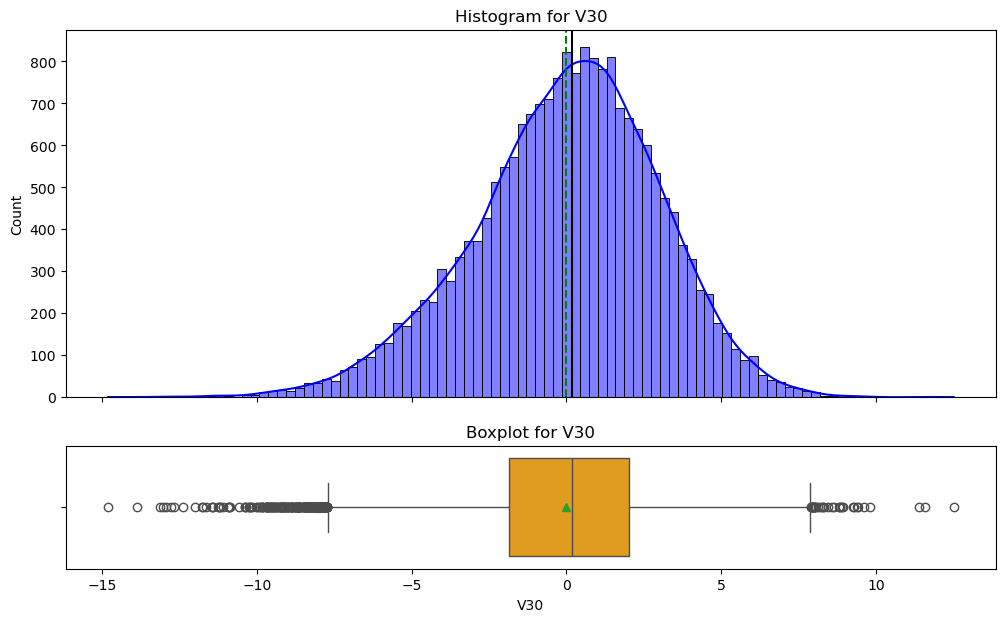

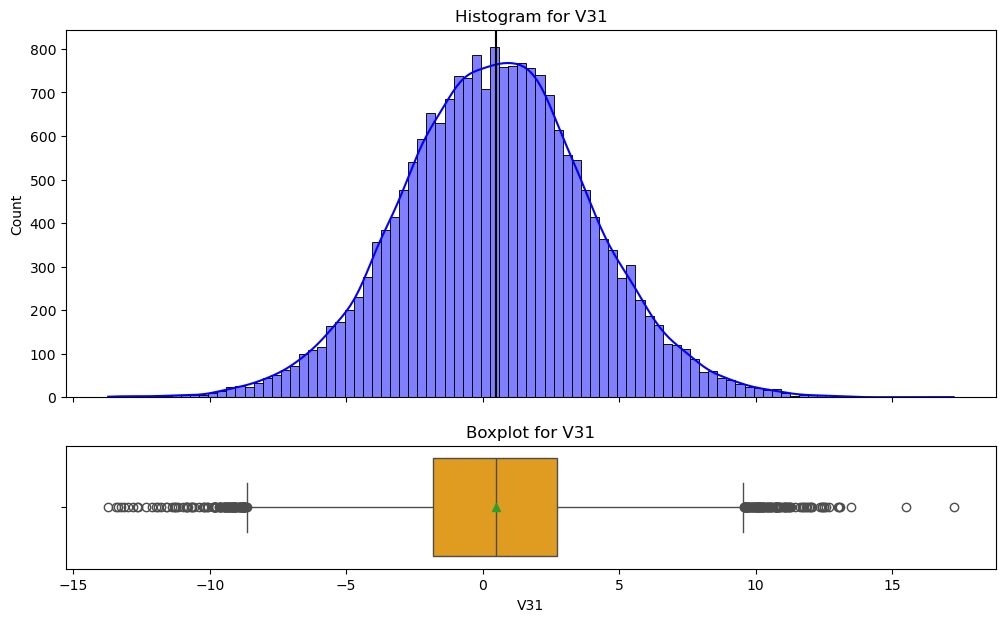

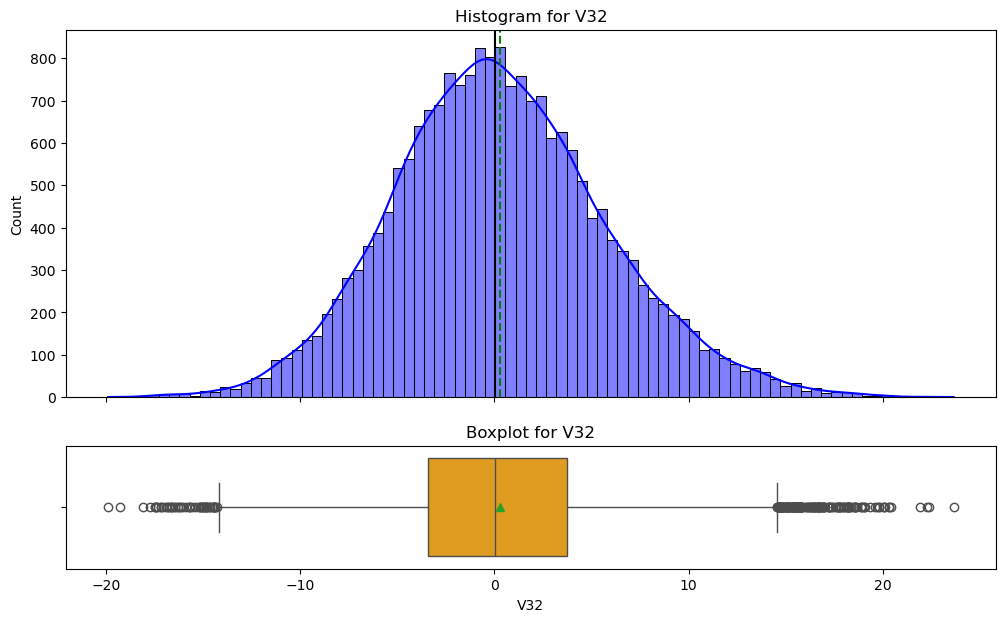

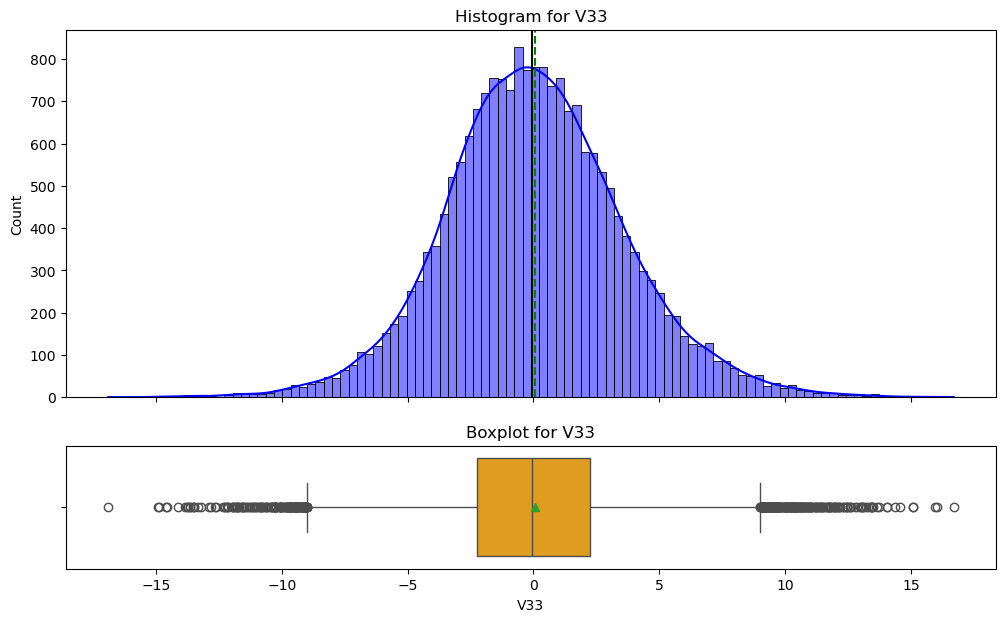

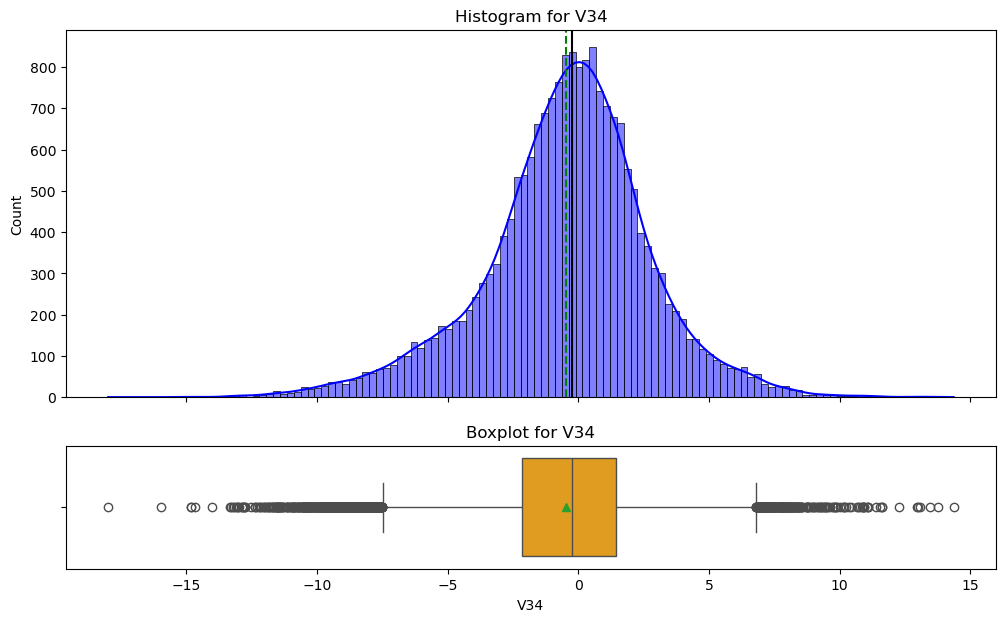

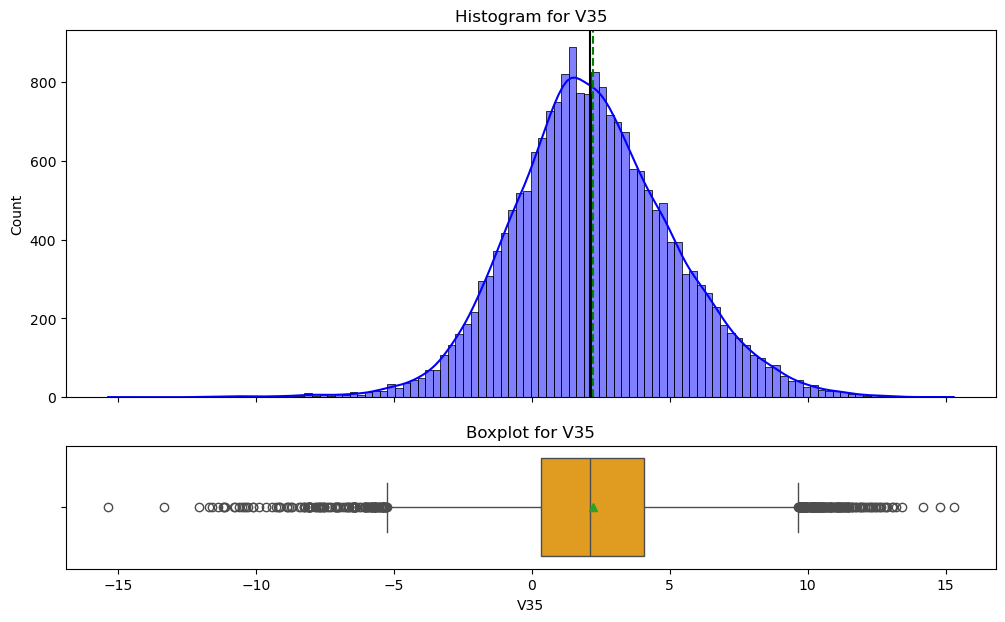

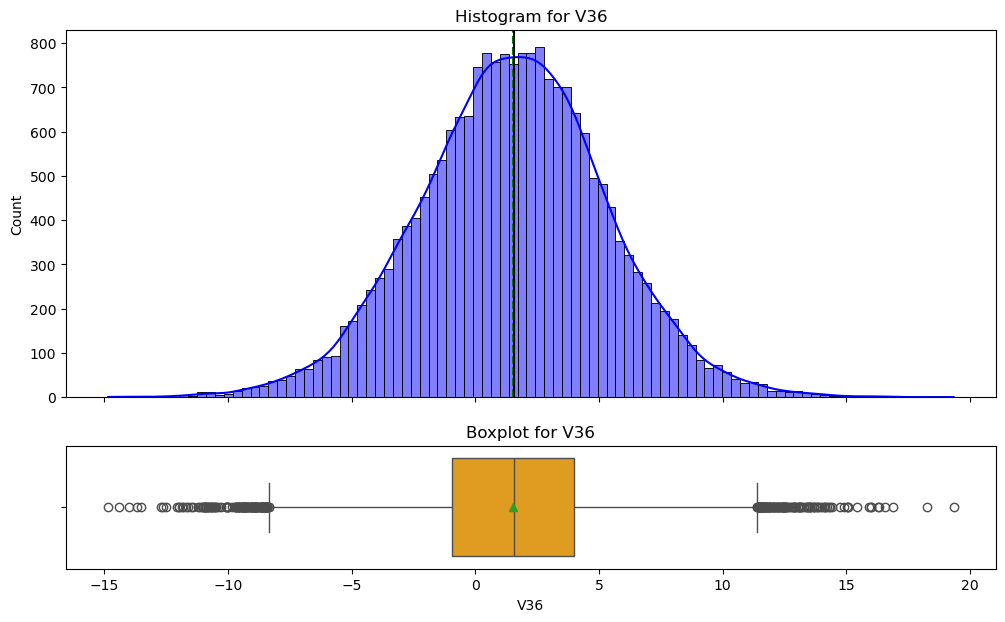

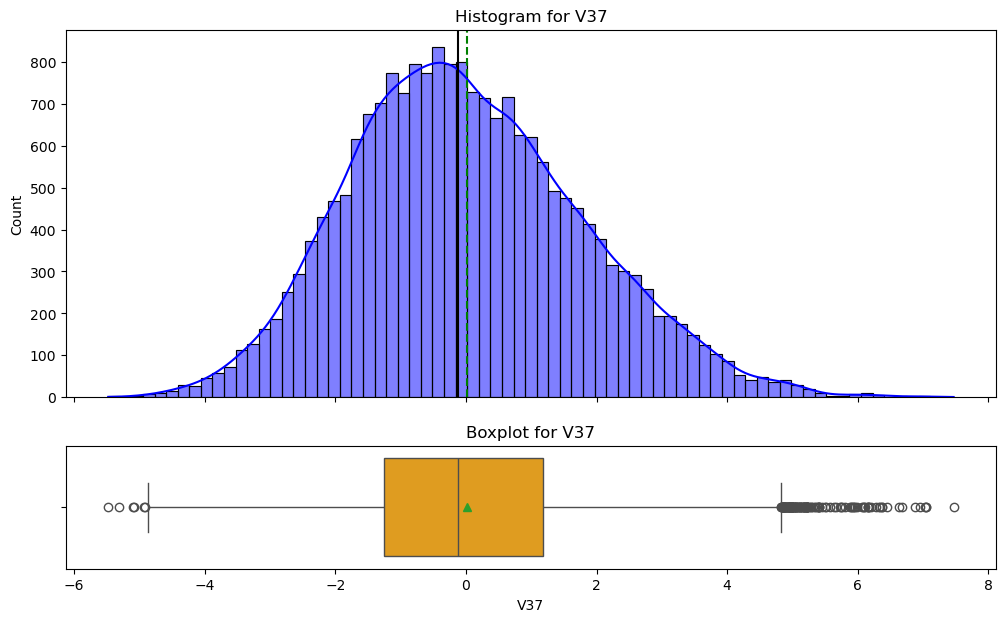

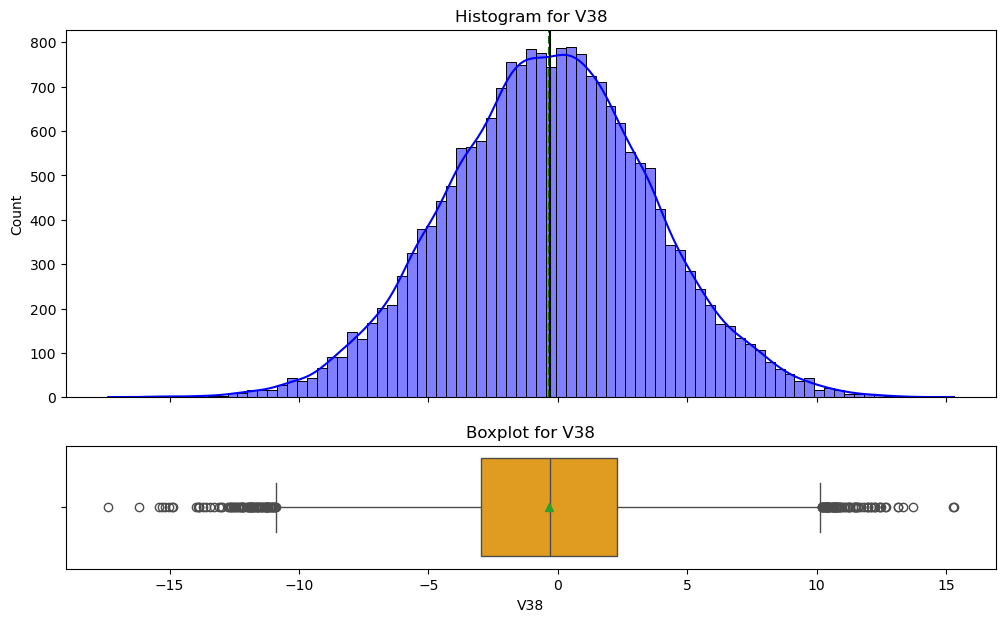

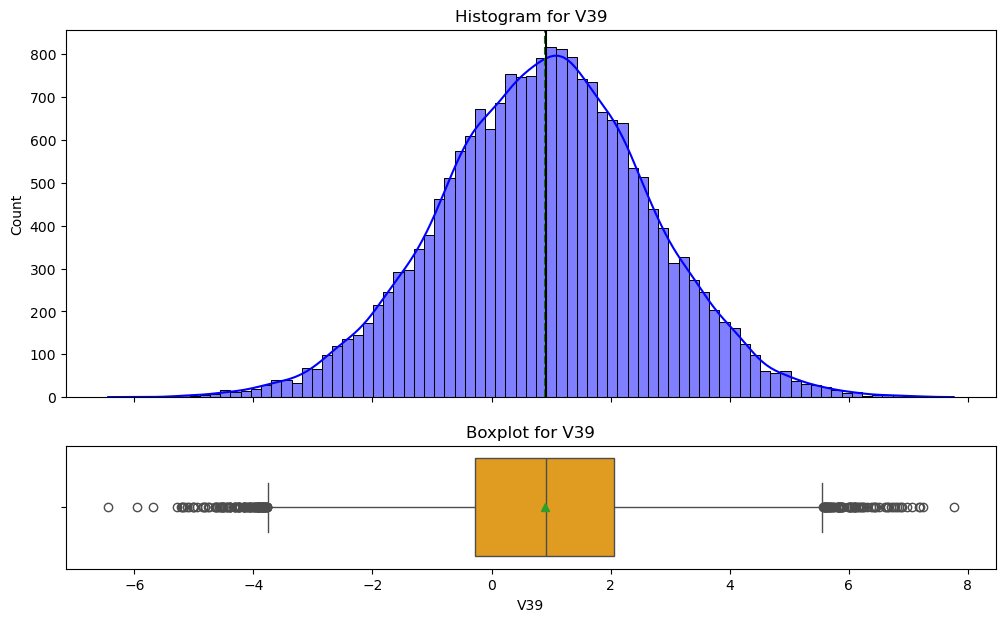

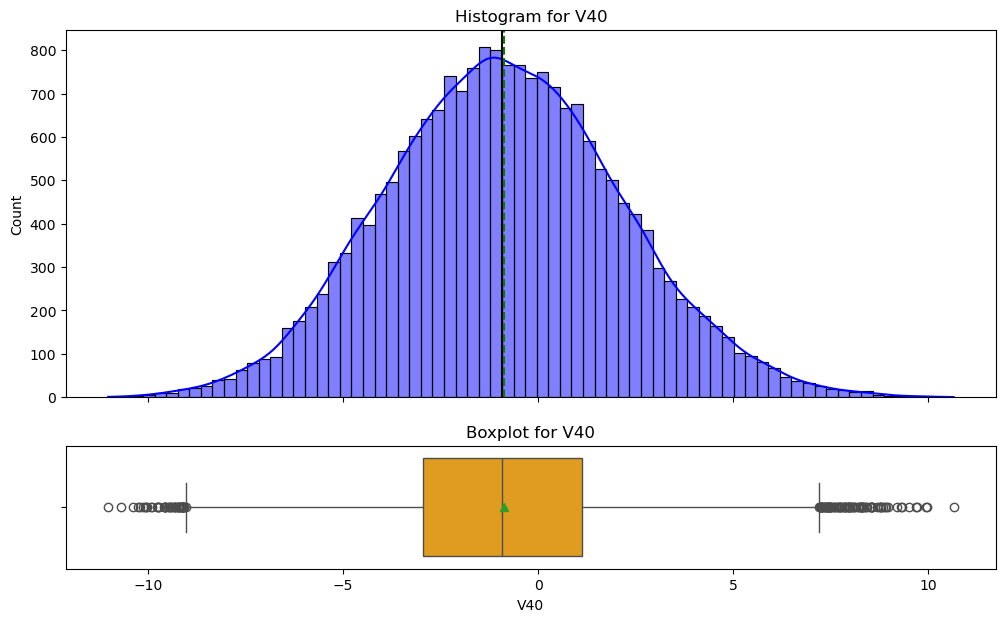

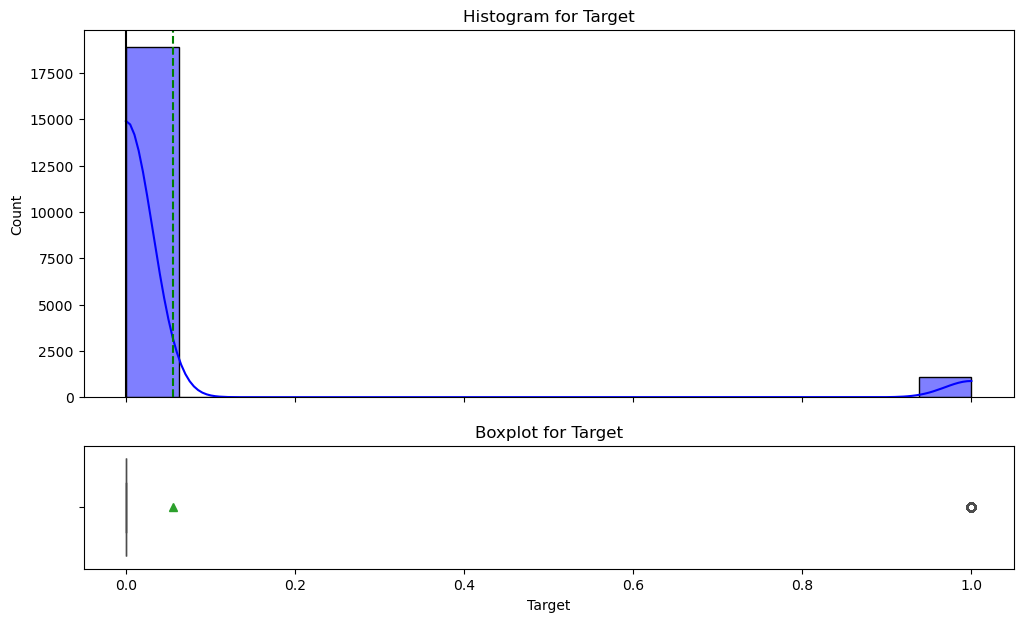

In [504]:
#Plot for each columns in dataframe

for feature in df.columns:
    univariate_analysis_for_numCols(df, feature, figsize=(12, 7)) 

**Observation**

- *The Histogram for almost all variables follow a `normal distributions`, with `little skewness on left and right` for few variables.*
  
- *The `boxplot` shows the `mean and median are almost same` for all variables, except for few where there are skewness present.*

- *`Outliers are present` at both the ends for all the variables, indicating extreme values.*

- *The data looks `standarized and normalized` for all variables.*

- *The data is `not balanced(Target)` as majority of data belongs to class=0(94%) while very less to class=1(6%).*

### Let's look at the values in target variable

In [505]:
#train set
train_value=df["Target"].value_counts()
train_value_perc=df["Target"].value_counts(normalize=True)

#print the results
print('Display value counts for target Train set:',train_value)       
print('Display value percentage for target Train set:',round(train_value_perc*100),2)
      


Display value counts for target Train set: Target
0    18890
1     1110
Name: count, dtype: int64
Display value percentage for target Train set: Target
0   94.000
1    6.000
Name: proportion, dtype: float64 2


In [506]:
#test set
test_value=df_test["Target"].value_counts()
test_value_perc=df_test["Target"].value_counts(normalize=True)

#print the results
print('Display value counts for target Test set:',test_value)       
print('Display value percentage for target Test set:',round(test_value_perc*100),2)
      

Display value counts for target Test set: Target
0    4718
1     282
Name: count, dtype: int64
Display value percentage for target Test set: Target
0   94.000
1    6.000
Name: proportion, dtype: float64 2


- *Class  distribution are same in both train and test set. i.e. `94%(class=0) and 6%(class=1).`*

## Data Pre-processing

**Identify & divide the dependent(Target) and independent(Predictors) variables** 

In [507]:
#dividing train data into X (predictor) and y (target)

#predictor (independent variables)
X = df.drop(["Target"], axis=1)

#target varaible
y = df["Target"]

- Since we already have a separate test set, we don't need to divide data into train, validation and test.

**Splitting train dataset into training and validation set**

In [508]:
# Splitting train dataset into training and validation set in the ratio 75:25

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.25, random_state=1,stratify=y)


In [509]:
#Print the shape of X train/validation set
print('Shape of Training set : ', X_train.shape)
print('Shape of validation set : ', X_val.shape)

#Print percentage of class in train/validation set
print('Percentage of classes in training set:')
print(y_train.value_counts(normalize=True))
print("Percentage of classes in validation set:")
print(y_val.value_counts(normalize=True))

Shape of Training set :  (15000, 40)
Shape of validation set :  (5000, 40)
Percentage of classes in training set:
Target
0   0.945
1   0.055
Name: proportion, dtype: float64
Percentage of classes in validation set:
Target
0   0.944
1   0.056
Name: proportion, dtype: float64


**Dividing test data into X and y**

In [510]:
# Dividing test data into X and y
X_test = df_test.drop(["Target"], axis=1)  #predictors
y_test = df_test["Target"]                 #target

In [511]:
print('Shape of Test set : ', X_test.shape)
print('Percentage of classes in test set:')
print(y_test.value_counts(normalize=True))

Shape of Test set :  (5000, 40)
Percentage of classes in test set:
Target
0   0.944
1   0.056
Name: proportion, dtype: float64


## Missing value imputation




Here we are using `Simple Imputer` (a preprocessing tool to handle missing values in given dataset) using strategy `median`.
  
In general `SimpleImputer` does the following:<br>

    1. Identifies the missing values (NaN) in numerical columns. <br>
    2. Calculates the value of each column based on strategy(here it's median).<br>
    3. Replaces NaN values with the calculated the strategy defined (median here).<br>

- *Imputing the dataset after splitting prevent data leakeage*.

In [512]:
# creating an instance of the imputer to be used
imputer = SimpleImputer(strategy="median") 

In [513]:
# Code to impute missing values in X_train,X_val, X_test to prevent data leakage

# Fit and transform the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Transform the validation data
X_val = pd.DataFrame(imputer.fit_transform(X_val), columns=X_val.columns)

# Transform the test data
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns=X_test.columns)

In [514]:
# Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print("-" * 50)

## Code to check the count of missing values in validation set
print(X_val.isna().sum()) 
print("-" * 50)

## Code to check the count of missing values in test set
print(X_test.isna().sum()) 
print("-" * 50)

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
--------------------------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
--------------------------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0

**observation**

- *`No missing values` are observed in any of the split dataset(Train,Validation or Test) `after imputing` the values with median values using Simple Imputer.*
  
- *With data split and transform, lets build the Model and also evaluate the criteria for best performances and minimum losses*

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are `failures correctly predicted` by the model.
- False negatives (FN) are `real failures` in a generator `where there is no detection by model`.
- False positives (FP) are `failure detections` in a generator `where there is no failure`.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want `Recall to be maximized `as `greater the Recall`, the `higher the chances of minimizing false negatives`.
* We want to `minimize false negatives` because if a model predicts that a `machine will have no failure when there will be a failure,` it will `increase the maintenance cost`(replacement cost).
  
* As we know the cost of repairing a generator is much less than the `cost of replacing(FN) `it, and the cost of inspection is less than the cost of repair.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [515]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1

        },
        index=[0],
    )

    return df_perf

In [516]:
#defining a function to plot the confusion_matrix of a classification model

def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to `reduce false negatives` and will try to `maximize "Recall`.
- To maximize Recall, we can use Recall as a **`scorer`** in cross-validation and hyperparameter tuning.

`The cross-validation recall score` is the average recall score obtained by splitting the training data (X_train, y_train) into 5 folds `(if using StratifiedKFold(n_splits=5)).` The model is trained on 4 folds and tested on the remaining fold. This process repeats for all 5 folds, and the mean recall score is printed.

After selecting the best model based on CV results, each model is retrained on the entire training dataset (X_train, y_train) and tested on completely unseen validation data (X_val, y_val). `The recall score computed here` helps check if the model overfits or generalizes well(i.e. comparing the CV score(training) with actual validation (recall)score.

**`Recall_score computation`**

In [517]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

#### **`Build 7 classification models using original train data`**  (*`Using logistic regression, decision trees, random forest, bagging classifier & boosting methods( Adaboost, Xgboost and GBM`)*


1. `Create` an `empty list` to store all the models.
2. `Appends all the models` into the list.
3. Create `empty list` to `store` all model's `CV scores results1[]` and another to store name of the models `names = []`.
4. loop through all models to get the `mean cross validated score `for train set.
5. loop through all models to get the `validation performance` (name, scores).

**Note:** `%%time` is used to calculate the overall time, while `import time` will calculate the start and end time of each module.


In [518]:
%%time
#overall time taken to execute the whole cell

import time

models = []  # Empty list to store all the models

# Appending models into the list

models.append(("Logistic Regression", LogisticRegression(random_state=1)))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results1 = []  # Empty list to store all model's CV scores
names = []     # Empty list to store name of the models


# loop through all models to get the mean cross validated score for train set
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")  
# loop through all models to get the validation performance 
for name, model in models:
    start_time = time.time()                            # Start time  using time function, to record time taken by each models 
    model.fit(X_train, y_train)                         #Fits each model on the training dataset (X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))  #Evaluates on validation set (X_val, y_val) using recall score.
    end_time = time.time()                              # End time
    print("{}: {} (Time taken: {:.2f} seconds)".format(name, scores, end_time - start_time))
   


Cross-Validation performance on training dataset:

Logistic Regression: 0.4927566553639709
dtree: 0.6982829521679532
Bagging: 0.7210807301060529
Random forest: 0.7235192266070268
GBM: 0.7066661857008874
Adaboost: 0.6309140754635308
Xgboost: 0.8100497799581561

Validation Performance:

Logistic Regression: 0.4856115107913669 (Time taken: 0.09 seconds)
dtree: 0.7050359712230215 (Time taken: 3.29 seconds)
Bagging: 0.7302158273381295 (Time taken: 22.83 seconds)
Random forest: 0.7266187050359713 (Time taken: 28.30 seconds)
GBM: 0.7230215827338129 (Time taken: 49.19 seconds)
Adaboost: 0.6762589928057554 (Time taken: 10.18 seconds)
Xgboost: 0.8309352517985612 (Time taken: 0.76 seconds)
CPU times: total: 5min 55s
Wall time: 9min 15s


**Observation**

From the above functions for 7 different models `(Logistic, decision tree, Bagging, Random Forrest, GBM, Adaboost and Xgboost)` with default values, we can observe that,

- *The `cross validation score` of `each models` are calculated for each `K-fold(here it's 5)` and appended and `stored in cv_result`, then the `mean of these scores` are taken and displayed for each models.*

- *The `mean cross validation` score is `minimum for Logistic Regression(~0.49)` while `maximum for Xgboost(~0.81)`.*
- *The `mean cv score` on `training set` for `most` of the models `except Logistic Regression & Xgboost`, lies in the range between `(0.69 - 0.72)`*

- *`All the models `are generalizing well on validation dataset, `with no or little overfitting.`*

- *`Logistic Regression `is generalizing well on validation data and `more stable (~.48 Recall score)`, however the `recall score is very low `and model need to be tuned/oversample/undersample to improve model increase recall score.*

- *`Decision tree` is giving `higher recall score(0.70)` compared to `logistic regression` and also generalizing well on unseen validation data.*

- *`Bagging and GBM `all are giving `high recall score(~ 0.73)` on validation set and slightly more than training set.*
- *`Random Forest` is also giving `stable high recall(~0.72)` on both training and validation set.*

- *`Xgboost `is giving the `highest recall (0.83)` on validation and .081 on training set, suggesting slight overfitting.*

- *Best on the performance on validation set and time taken `XgBoost(highest recall- 0.83) and Random Forest`(comparable recall compared to Bagging,dtree and GBM but more stable) `is doing better`.*

- *The overall time taken to `run 7 models` with CV 5 k-folds, took around .`Logistic regression and Xgboost` took the `least time`.* 

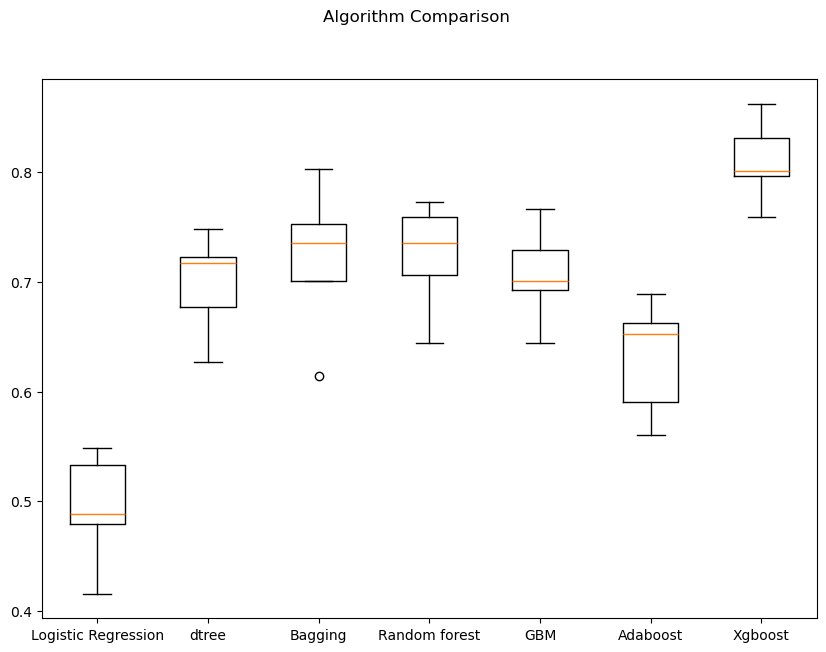

In [519]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

**Observation**

From the above boxplots for 7 different models(Logistic,decision tree,Bagging,Random Forrest,GBM,Adaboost and Xgboost) we can observe that,

- *`Logistic regression` has the `minimum (~0.49)` and  `Xgboost(~0.81)` has the `maximum mean cross validation` score.*
  
- *The `mean cv score` on `training set` for `most` of the models `except Logistic Regression & Xgboost`, lies in the range between `(0.69 - 0.72)`*

- *`One Outlier` is present for `Bagging classifier` at lower end, pushing the mean cv score little closer to median.*

- *`Mean and median for Random forest` is almost same, indicating consistent scores and stability in the model.*

- *Wider box in Adaboost indicate, more variation in CV score suggesting model will be less stable.*

- *`GBM and XGboost` show less variations in CV scores.* 

### Model Building with Oversampled data


In [520]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))


Before OverSampling, counts of label '1': 832
Before OverSampling, counts of label '0': 14168 



- *we can see from above result the `y_train` is `highly imbalanced` [ class 1 is 832 while class 0 is 14,168 ]*.
  
- *we can `try oversampling (increase training data)` using `SMOTE ( Synthetic Minority Over Sampling Technique) technique` to see if the model performance can be improved.*

#### **`Build 7 classification models using oversampled train data`**  (*`Using logistic regression, decision trees, random forest, bagging classifier & boosting methods( Adaboost, Xgboost and GBM`)*

In [521]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))


print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

After OverSampling, counts of label '1': 14168
After OverSampling, counts of label '0': 14168 

After OverSampling, the shape of train_X: (28336, 40)
After OverSampling, the shape of train_y: (28336,) 



- *Now the class 1 and 0 `both are balanced (14168)` after oversampling.*
- *The `number of rows has increased ` to double it's original size due to oversampling` the data in class 1.*

In [522]:
%%time 
import time


models = []  # Empty list to store all the models

# Appending models into the list

models.append(("Logistic Regression", LogisticRegression(random_state=1)))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    start_time = time.time()  # Start time
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    end_time = time.time()  # End time
    print("{}: {} (Time taken: {:.2f} seconds)".format(name, scores, end_time - start_time))
    #print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic Regression: 0.883963699328486
dtree: 0.9720494245534969
Bagging: 0.9762141471581656
Random forest: 0.9839075260047615
GBM: 0.9256068151319724
Adaboost: 0.8978689011775473
Xgboost: 0.9891305241357218

Validation Performance:

Logistic Regression: 0.4856115107913669 (Time taken: 0.09 seconds)
dtree: 0.7050359712230215 (Time taken: 3.31 seconds)
Bagging: 0.7302158273381295 (Time taken: 22.78 seconds)
Random forest: 0.7266187050359713 (Time taken: 28.03 seconds)
GBM: 0.7230215827338129 (Time taken: 49.60 seconds)
Adaboost: 0.6762589928057554 (Time taken: 10.09 seconds)
Xgboost: 0.8309352517985612 (Time taken: 0.77 seconds)
CPU times: total: 9min 3s
Wall time: 14min 24s


**Observation**

From the above functions for 7 different models `(Logistic, decision tree, Bagging, Random Forrest, GBM, Adaboost and Xgboost)` with oversampled data, we can observe that,

- *The `mean cross validation` score is is `highly improved` for all the modeles on training set`(range ~0.88- 0.98) ` but `poorly` on Validation test set, `indicating overfitting`*

- *`Logistic Regression `is generalizing poorly on validation data `(~.48 cv score)`.*
-  *`Decision tree, Bagging, Random forest  are giving `higher cv score(~ 0.98)`  but again poorly on unseen validation data(~ 0.70 - 0.73 range).*

- *`Adaboost and GBM ` are giving `high cv score(~ 0.90 -0.93 range)` on training set but less on validation set.*

- *`Xgboost `is giving the `highest recall (0.83)` again on validation and .098 on training set, but overfitting little.*

- *Based on the performance on validation set `XgBoost(highest recall- 0.83)  `is doing better` than other models in term of time and overfitting and giving high recall value on validation set*

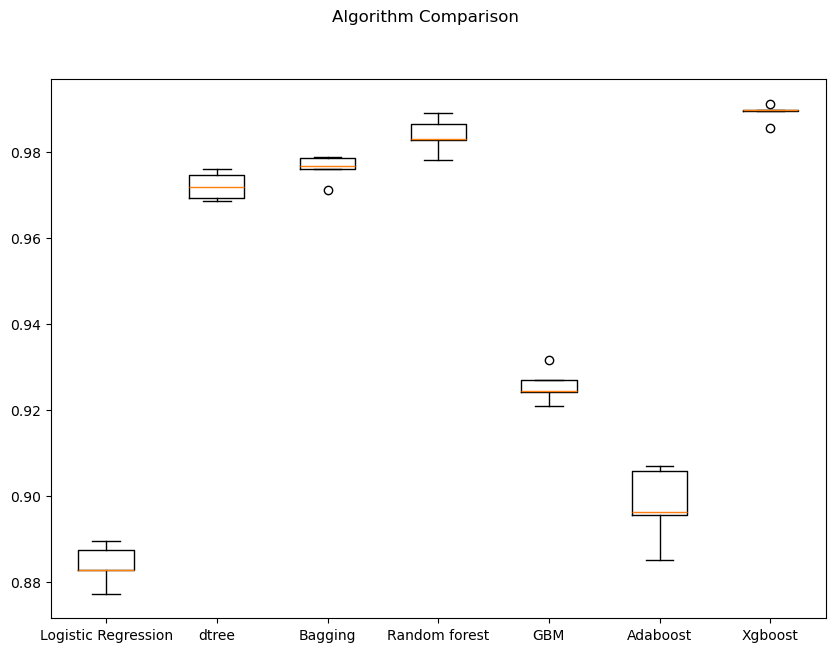

In [523]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

**Observation:**

- *The `mean cross validation` score is is `highly improved` for all the modeles on training set`(range ~0.88- 0.98) ` but `poorly` on Validation test set, `indicating overfitting`*
- *Few `outliers` are present for `GBM, Bagging and Xgboost`, indicating variation in cv scores in different folds*.
- *No box is visible in IQR range for XGboost suggesting CV scores are almost similar and less variation and spread.*
- *The `mean and median` value for `decision tree` are almost similar, indicating most of the cv scores lies in IQR range.*

### Model Building with Undersampled data

- *we know from earlier analysis the `y_train` is `highly imbalanced` [ class 1 is 832 while class 0 is 14,168 ]*.
  
- *we have tried building model with oversample data, the models did well on training but poorly on validation set.*

- lets `try undersampling (decrease training data)` using `Random Undersampler ` method to see if the model performance can be improved and problem of overfiiting can be solved*

In [524]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)


print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))


print("After UnderSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))


print("After UnderSampling, the shape of train_X: {}".format(X_train_un.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before UnderSampling, counts of label '1': 832
Before UnderSampling, counts of label '0': 14168 

After UnderSampling, counts of label '1': 832
After UnderSampling, counts of label '0': 832 

After UnderSampling, the shape of train_X: (1664, 40)
After UnderSampling, the shape of train_y: (1664,) 



- *The sample size is reduced to 1664 for train set after undersampling of data*

#### **`Build 7 classification models using under sampled train data`**  (*`Using logistic regression, decision trees, random forest, bagging classifier & boosting methods( Adaboost, Xgboost and GBM`)*

In [525]:
%%time 
import time


models = []  # Empty list to store all the models

# Appending models into the list

models.append(("Logistic Regression", LogisticRegression(random_state=1)))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    start_time = time.time()  # Start time
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    end_time = time.time()  # End time
    print("{}: {} (Time taken: {:.2f} seconds)".format(name, scores, end_time - start_time))
    #print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic Regression: 0.8726138085275232
dtree: 0.8617776495202367
Bagging: 0.8641945025611427
Random forest: 0.9038669648654498
GBM: 0.8978572974532861
Adaboost: 0.8666113556020489
Xgboost: 0.9014717552846114

Validation Performance:

Logistic Regression: 0.4856115107913669 (Time taken: 0.09 seconds)
dtree: 0.7050359712230215 (Time taken: 3.42 seconds)
Bagging: 0.7302158273381295 (Time taken: 22.48 seconds)
Random forest: 0.7266187050359713 (Time taken: 28.23 seconds)
GBM: 0.7230215827338129 (Time taken: 49.37 seconds)
Adaboost: 0.6762589928057554 (Time taken: 9.99 seconds)
Xgboost: 0.8309352517985612 (Time taken: 0.78 seconds)
CPU times: total: 1min 51s
Wall time: 2min 32s


**Observation**

- *We do not see `much improvement in recall score on validation set`. They are almost the same as oversampled data.*
- *The `mean cv score range from (0.86 - 0.90) `on training set but little less than oversampled data.*
- *The `problem of overfitting is reduced little` but not much.*

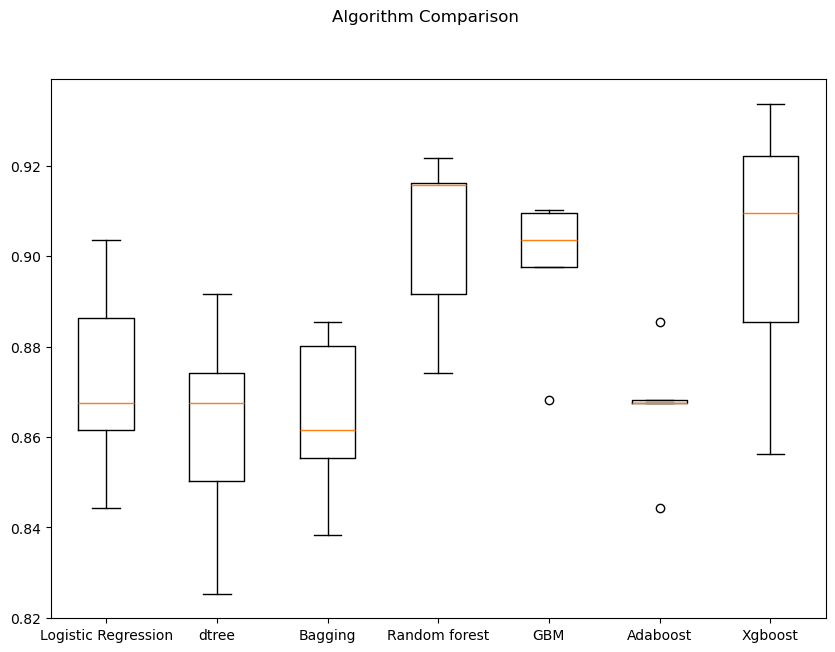

In [526]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

**Observation**

- *We do not see `much improvement in recall score on validation set`. They are almost the same as oversampled data.*
- *The `cv score range from (0.83 - 0.94) `on training set for different models.*
- *The `cv score` in IQR range for `logistic regression, dtree and bagging` are almost in similar `range(0.85 - 0.89)`.*
- *The `cv score` in IQR range for `random Forest, GBM and Xgboost` are little high `(range 0.88- 0.92)`.*
- *Few outliers are present for GBM and Adaboost.*

## HyperparameterTuning

Based on on above default,Over and under sample models built, `lets tune 7 best models` to `improve the performance and reducing overfitting problem`.
XGboost,Random Forest,GBM and Adaboost mostly with over sampled data, as all these models are giving high recall and generalizing well on validation data for all metrics. However all these models are suffering from overfitting issues, lets see if we can resolve this problem by tuning them further. 
under sampled models are also giving good generalize result and similar recall range, but I'm not selecting them, because there are good chances of missing on important information because of under sampling.

For this I've selected below models to tune, <br>
1. `Xgboost default` (Using random search) (1 model) 
2. `XGboost oversampled` using both Grid and Random search( 2 model)
3. `Random forest` (Using random search) with `oversample/undersample `data ( 2 model)
4. `GBM (Using random search)` using `undersample` data (1 model)
5. `Adabooster (using Random search)` using `oversampled` (1 model)

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1],
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6),
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

### Model 1: Tuning method for Xgboost with original data

**Step 1: Tuned the model to get best parameters using random search and cv**

In [527]:
%%time
# defining model
Model = XGBClassifier(random_state=1,eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid={ 
            'n_estimators': [150, 200, 250], 
            'scale_pos_weight': [5,10], 
            'learning_rate': [0.1,0.2], 
            'gamma': [0,3,5], 
            'subsample': [0.8,0.9]
            }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

# Start time
start_time = time.time() 

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

# End time
end_time = time.time()  

print("Best parameters are {} with CV score={}:, (Time taken: {:.2f} seconds)" 
      .format(randomized_cv.best_params_,randomized_cv.best_score_, end_time - start_time))

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.2, 'gamma': 5} with CV score=0.8582136930957363:, (Time taken: 81.98 seconds)
CPU times: total: 6.72 s
Wall time: 1min 21s


**Step 2: Fit the model with best parameter**

In [528]:
%%time

# Code with the best parameters obtained from tuning with original data
xgb_def = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.8,
    scale_pos_weight=10,
    n_estimators=200,
    learning_rate=0.2,
    gamma=5,
)

## Code to fit the model on original data
xgb_def.fit(X_train,y_train) 

CPU times: total: 4.2 s
Wall time: 794 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

**Step 3: Check the `Train performance` and confusion matrix**

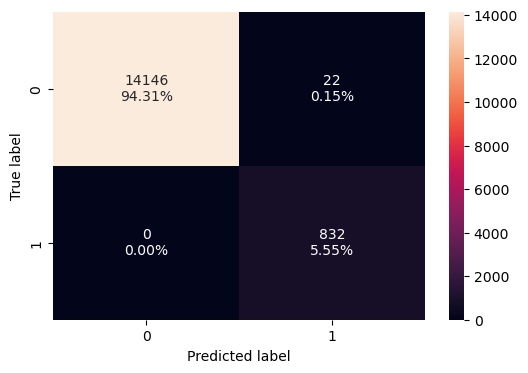

In [529]:
confusion_matrix_sklearn(xgb_def, X_train,y_train)

In [530]:
# Code to check the performance on original train set
xgb_def_train_perf =  model_performance_classification_sklearn(xgb_def, X_train,y_train)
xgb_def_train_perf

,Accuracy,Recall,Precision,F1
0,0.999,1.000,0.974,0.987


**Step 4: Check the `Validation` performance and confusion matrix on**

In [531]:
# Code to check the performance on validation set
xgb_def_val_perf =  model_performance_classification_sklearn(xgb_def, X_val,y_val)
xgb_def_val_perf

,Accuracy,Recall,Precision,F1
0,0.987,0.849,0.911,0.879


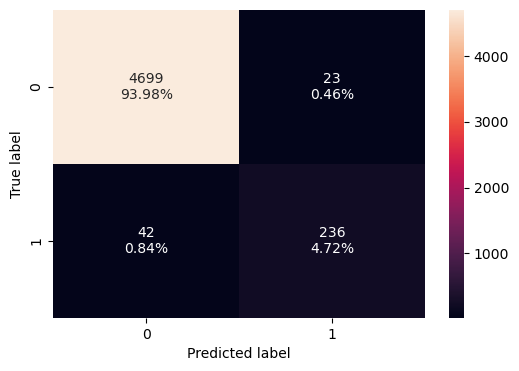

In [532]:
confusion_matrix_sklearn(xgb_def, X_val,y_val)

**Observation**

- *The model is performing well on `training data((Recall= 1)`and also on `Validation set (Recall~ 0.85)`. But we still see overfitting issues esp for recall and F1 score. Lets tuned other model to check if we can achieve higher recall with less overfitting of train data.*

### Model 2: Tuning method for Xgboost with oversampled data (Grid Search)

**Step 1: Tuned the model to get best parameters (using Grid search) and cv**

In [533]:
%%time
# defining model
Model = XGBClassifier(random_state=1,eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid={
        'n_estimators':[150,200,250],
        'scale_pos_weight':[5,10], 
        'learning_rate':[0.1,0.2], 
        'gamma':[0,3,5], 
        'subsample':[0.8,0.9],
        #'reg_alpha': [0.1]
        }

#Calling gridsearchCv
Grid_cv = GridSearchCV(Model, param_grid, n_jobs = -1, scoring=scorer, cv=5)

# Start time
start_time = time.time() 

#Fitting parameters in RandomizedSearchCV for oversampled data
Grid_cv.fit(X_train_over,y_train_over)

# End time
end_time = time.time()  

print("Best parameters are {} with CV score={}:, (Time taken: {:.2f} seconds)" 
      .format(Grid_cv.best_params_,Grid_cv.best_score_, end_time - start_time))

Best parameters are {'gamma': 0, 'learning_rate': 0.1, 'n_estimators': 250, 'scale_pos_weight': 10, 'subsample': 0.9} with CV score=0.9961181368591415:, (Time taken: 189.64 seconds)
CPU times: total: 45.2 s
Wall time: 3min 9s


In [534]:
%%time

# Code with the best parameters obtained from tuning with oversampled data
xgb_over_gr = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.9,
    scale_pos_weight=10,
    n_estimators=250,
    learning_rate=0.1,
    gamma=0,
  #  reg_alpha= 0.1
)

## Code to fit the model on oversampled data
xgb_over_gr.fit(X_train_over,y_train_over) 

CPU times: total: 14.7 s
Wall time: 2.8 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

**Check the performance on Train and Validation set**

In [535]:
# Code to check the performance on oversampled train set
xgb_over_gr_train_perf =  model_performance_classification_sklearn(xgb_over_gr,X_train_over,y_train_over)
xgb_over_gr_train_perf

,Accuracy,Recall,Precision,F1
0,0.999,1.000,0.999,0.999


In [536]:
# Code to check the performance on validation set
xgb_over_gr_val_perf =  model_performance_classification_sklearn(xgb_over_gr, X_val,y_val)
xgb_over_gr_val_perf

,Accuracy,Recall,Precision,F1
0,0.983,0.881,0.825,0.852


**Observation**
- *The model is generalizing well compared to original data. The recall is `improved to ~0.88 from 0.85`. The problem of overfitting is still not solved.*

### Model 3: Tuning method for Xgboost with oversampled data (using random search)

In [537]:
%%time
# defining model
Model = XGBClassifier(random_state=1,eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid={
        'n_estimators':[150,200,250],
        'scale_pos_weight':[5,10], 
        'learning_rate':[0.1,0.2], 
        'gamma':[0,3,5], 
        'subsample':[0.8,0.9],
        #'reg_alpha': [0.1]
        }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

# Start time
start_time = time.time() 

#Fitting parameters in RandomizedSearchCV for oversampled data
randomized_cv.fit(X_train_over,y_train_over)

# End time
end_time = time.time()  

print("Best parameters are {} with CV score={}:, (Time taken: {:.2f} seconds)" 
      .format(randomized_cv.best_params_,randomized_cv.best_score_, end_time - start_time))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 150, 'learning_rate': 0.1, 'gamma': 0} with CV score=0.9960475154078072:, (Time taken: 128.21 seconds)
CPU times: total: 27.7 s
Wall time: 2min 8s


**Fit the tuned model**

In [538]:
%%time

# Code with the best parameters obtained from tuning with oversampled data
xgb_over = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.9,
    scale_pos_weight=10,
    n_estimators=150,
    learning_rate=0.1,
    gamma=0,
  #  reg_alpha= 0.1
)

## Code to fit the model on oversampled data
xgb_over.fit(X_train_over,y_train_over) 

CPU times: total: 5.44 s
Wall time: 1.44 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

**Step 3: Check the `Train and validation performance`**


In [539]:
# Code to check the performance on oversampled train set
xgb_over_train_perf =  model_performance_classification_sklearn(xgb_over,X_train_over,y_train_over)
xgb_over_train_perf

,Accuracy,Recall,Precision,F1
0,0.994,1.000,0.988,0.994


In [540]:
# Code to check the performance on validation 
xgb_over_val_perf =  model_performance_classification_sklearn(xgb_over,X_val,y_val)
xgb_over_val_perf

,Accuracy,Recall,Precision,F1
0,0.967,0.892,0.648,0.750


**Observation**

- *The recall `has improved slightly to ~0.89`, but the overfitting issue has increased in other metrics(precision/f1).*

### Model 4: Tuning method for Random Forest with oversampled data

In [541]:
%%time

# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

# Start time
start_time = time.time() 

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over) ## Complete the code to fit the model on under sampled data

# End time
end_time = time.time()  

print("Best parameters are {} with CV score={}:, (Time taken: {:.2f} seconds)" 
      .format(randomized_cv.best_params_,randomized_cv.best_score_, end_time - start_time))

Best parameters are {'n_estimators': 200, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.9818606498020482:, (Time taken: 632.45 seconds)
CPU times: total: 46.2 s
Wall time: 10min 32s


**Fit the model with best parameters**

In [542]:
%%time
# Fit the model with best parameters
tuned_rf_over = RandomForestClassifier(
    max_features='sqrt',
    random_state=1,
    max_samples=0.6,
    n_estimators=200,
    min_samples_leaf=1
)

tuned_rf_over.fit(X_train_over,y_train_over) 

CPU times: total: 29.3 s
Wall time: 51.9 s


RandomForestClassifier(max_samples=0.6, n_estimators=200, random_state=1)

**Step 3: Check the `Train performance`**


In [543]:
# Code to check the performance on oversampled train set
tuned_rf_over_train_perf = model_performance_classification_sklearn(tuned_rf_over,X_train_over,y_train_over) 
tuned_rf_over_train_perf

,Accuracy,Recall,Precision,F1
0,1.000,0.999,1.000,1.000


**Step 4: Check the `Validation` performance**


In [544]:
## Code to check the performance on validation set
tuned_rf_over_val_perf =  model_performance_classification_sklearn(tuned_rf_over,X_val,y_val) 
tuned_rf_over_val_perf

,Accuracy,Recall,Precision,F1
0,0.988,0.863,0.920,0.891


**Observation**

- *The recall `has decreased slightly to ~0.86`, but the overfitting issue has decreased in other metrics(precision/f1).Though it took more time(7 min overall) compared to XGboost(1-2 min)*

### Model 5: Tuning method for Random Forest with undersampled data

In [545]:
%%time

# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

# Start time
start_time = time.time() 

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un) ## Complete the code to fit the model on under sampled data

# End time
end_time = time.time()  

print("Best parameters are {} with CV score={}:, (Time taken: {:.2f} seconds)" 
      .format(randomized_cv.best_params_,randomized_cv.best_score_, end_time - start_time))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 2, 'max_samples': 0.5, 'max_features': 'sqrt'} with CV score=0.8990116153235697:, (Time taken: 32.52 seconds)
CPU times: total: 3.77 s
Wall time: 32.5 s


**fit the model with best parameters**

In [546]:
%%time
# Fit the model with best parameters
tuned_rf_un = RandomForestClassifier(
    max_features='sqrt',
    random_state=1,
    max_samples=0.5,
    n_estimators=300,
    min_samples_leaf=2
)

tuned_rf_un.fit(X_train_un,y_train_un) 

CPU times: total: 1.67 s
Wall time: 2.95 s


RandomForestClassifier(max_samples=0.5, min_samples_leaf=2, n_estimators=300,
                       random_state=1)

In [547]:
# Code to check the performance on oversampled train set
tuned_rf_un_train_perf = model_performance_classification_sklearn(tuned_rf_un,X_train_un,y_train_un) 
tuned_rf_un_train_perf

,Accuracy,Recall,Precision,F1
0,0.961,0.933,0.989,0.960


In [548]:
## Code to check the performance on validation set
tuned_rf_un_val_perf =  model_performance_classification_sklearn(tuned_rf_un,X_val,y_val) 
tuned_rf_un_val_perf

,Accuracy,Recall,Precision,F1
0,0.938,0.885,0.468,0.612


**Observation**

- *The recall `has increased to ~0.89` and `overfitting issue is reduced for recall`, but the overfitting issue has `increased` in other metrics (precision/f1).*

### Model 6: Tuning Gradient Boosting using oversampled data

**Step 1: Tuned the model using random search**

In [549]:
%%time

# defining model
Model = GradientBoostingClassifier(random_state=1)

#Parameter grid to pass in RandomSearchCV
param_grid={"n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7]}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, scoring=scorer, n_iter=50, n_jobs = -1, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.972756012725313:
CPU times: total: 35 s
Wall time: 7min 20s


**Step 2: Fit the model with best parameter**

In [550]:
%%time
# Fit the model with best parameters
tuned_gbm_over = GradientBoostingClassifier(
    max_features=0.5,
    random_state=1,
    learning_rate=1,
    n_estimators=125,
    subsample=0.7,
)

tuned_gbm_over.fit(X_train_over, y_train_over)

CPU times: total: 26.5 s
Wall time: 43.1 s


GradientBoostingClassifier(learning_rate=1, max_features=0.5, n_estimators=125,
                           random_state=1, subsample=0.7)

**Check the performance on train and validation**

In [551]:
# Code to check the performance on oversampled train set
tuned_gbm_over_train_perf =  model_performance_classification_sklearn(tuned_gbm_over,X_train_over,y_train_over)
tuned_gbm_over_train_perf

,Accuracy,Recall,Precision,F1
0,0.993,0.993,0.994,0.993


In [552]:
## Code to check the performance on validation set
tuned_gbm_over_val_perf =  model_performance_classification_sklearn(tuned_gbm_over,X_val,y_val) 
tuned_gbm_over_val_perf

,Accuracy,Recall,Precision,F1
0,0.971,0.845,0.693,0.762


**Observation**

- *The recall `has decreased to ~0.85` , but the overfitting issue has `increased` and model is not generalizing well on validation set*

### Model 7: Tuning AdaBoost using oversampled data

In [553]:
%%time

# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1),
                       DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV on over sampled data
randomized_cv.fit(X_train_over,y_train_over) 

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.971555946263926:
CPU times: total: 2min 15s
Wall time: 18min 6s


In [554]:
%%time
# Fit the model with best parameters
tuned_ada_over = AdaBoostClassifier(
    n_estimators= 200, learning_rate=0.2, estimator= DecisionTreeClassifier(max_depth=3, random_state=1)
) 

## Code to fit the model on oversampled data
tuned_ada_over.fit(X_train_over,y_train_over)

CPU times: total: 2min 12s
Wall time: 3min 37s


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    random_state=1),
                   learning_rate=0.2, n_estimators=200)

In [555]:
# Code to check the performance on oversampled train set
tuned_ada_over_train_perf = model_performance_classification_sklearn(tuned_ada_over,X_train_over,y_train_over) 
tuned_ada_over_train_perf

,Accuracy,Recall,Precision,F1
0,0.992,0.988,0.995,0.992


In [556]:
## Code to check the performance on validation set
tuned_ada_over_val_perf =  model_performance_classification_sklearn(tuned_ada_over,X_val,y_val) 
tuned_ada_over_val_perf

,Accuracy,Recall,Precision,F1
0,0.979,0.853,0.790,0.820


**Observation**

- *The recall `is stable to ~0.85` , but the  overall overfitting issue has `decreased` and model performance is okay*

#### **We have now tuned all the models, let's compare the performance of all tuned models and see which one is the best.**

## Model performance comparison and choosing the final model

In [557]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        tuned_gbm_over_train_perf.T,
        tuned_ada_over_train_perf.T,
        tuned_rf_un_train_perf.T,
        tuned_rf_over_train_perf.T,
        xgb_over_gr_train_perf.T,
        xgb_over_train_perf.T,
        xgb_def_train_perf.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Gradient Boosting tuned with oversampled data",
    "AdaBoost classifier tuned with oversampled data",
    "Random forest tuned with undersampled data",
    "Random forest tuned with oversampled data",
    "XGBoost tuned with oversampled data (grid search)",
    "XGBoost tuned with oversampled data",
    "XGBoost tuned with original data",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Gradient Boosting tuned with oversampled data,AdaBoost classifier tuned with oversampled data,Random forest tuned with undersampled data,Random forest tuned with oversampled data,XGBoost tuned with oversampled data (grid search),XGBoost tuned with oversampled data,XGBoost tuned with original data
Accuracy,0.993,0.992,0.961,1.000,0.999,0.994,0.999
Recall,0.993,0.988,0.933,0.999,1.000,1.000,1.000
Precision,0.994,0.995,0.989,1.000,0.999,0.988,0.974
F1,0.993,0.992,0.960,1.000,0.999,0.994,0.987


In [558]:
# validation performance comparison

models_validation_comp_df = pd.concat(
    [
        tuned_gbm_over_val_perf.T,
        tuned_ada_over_val_perf.T,
        tuned_rf_un_val_perf.T,
        tuned_rf_over_val_perf.T,
        xgb_over_gr_val_perf.T,
        xgb_over_val_perf.T,
        xgb_def_val_perf.T
    ],
    axis=1,
)
models_validation_comp_df.columns = [
    "Gradient Boosting tuned with oversampled data",
    "AdaBoost classifier tuned with oversampled data",
    "Random forest tuned with undersampled data",
    "Random forest tuned with oversampled data",
    "XGBoost tuned with oversampled data (grid search)",
    "XGBoost tuned with oversampled data",
    "XGBoost tuned with original data",
]
print("Validation performance comparison:")
models_validation_comp_df

Validation performance comparison:


,Gradient Boosting tuned with oversampled data,AdaBoost classifier tuned with oversampled data,Random forest tuned with undersampled data,Random forest tuned with oversampled data,XGBoost tuned with oversampled data (grid search),XGBoost tuned with oversampled data,XGBoost tuned with original data
Accuracy,0.971,0.979,0.938,0.988,0.983,0.967,0.987
Recall,0.845,0.853,0.885,0.863,0.881,0.892,0.849
Precision,0.693,0.790,0.468,0.920,0.825,0.648,0.911
F1,0.762,0.820,0.612,0.891,0.852,0.750,0.879


**observation**

- *`Tuned(random search) Xgboost with oversampled data` is giving `high Recall(1)` and very good performance on training set for all the metrics, but not generalizing well on `validation data(recall=0.89)`, indicating severe over fitting*
- *`Tuned(Grid search) Xgboost with oversampled` and `tuned Xgboost with original data` is giving `high recall` of 0.88 and 0.85 respectively on validation data. it's giving generalized performance on validation set for all metrics with little overfit as compared to oversampled data*.
  
- *`Tuned Random forest with undersample data` is giving `high recall(~ 0.89)` on validation set but like over sampled tuned XGboost is not generalizing well on other metrics(precision and f1 score). Also there are chances of missing important imformation because of undersampling od data*
  
- *`Random forest with oversampled `is also giving `high recall(0.86)` and generalizing well on validation set but overfitting little but better than tuned XGboost (grid search).*
- *`Tuned GB classifier with oversampled data` is also giving high recall`(~ 0.85)` on validation and performing similar to tuned XG boost oversampled.*
- *`All models` are suffering from `overfitting issue`, but few are genearlizing well on validation data for all metrics*.
  
- *We have also notice that the time taken by boosting classifier` like Adaboost(21 min) /Gradient booster(14 min)` and `(bagging) random forest(12 min)` with oversampled data are more when compared to `XGboost(2-3 min (for grid and random search)`.*
  
- *We can see `both oversampled tuned random forest and tuned XGboost(grid search)` is giving `high recall` and overall generalized score on all metrics keeping the things stable.*
  
- *Though the `runtime( run & CPU time) for tuned Random Forest is more compared to tuned XGboost`, the computational cost will be `low as its medium size` dataset, So we will go with tuned Random forest as `it's more stable and less overfitting `and `recall is comparable`.*
  
- *Thus we will choose **`Oversampled tuned Random Forest`** as our **`final best model`***, *and test it further it's performance on testdata*.

**Now we have our final model, so let's find out how our final model is performing on unseen test data.**

### Test set final performance

In [559]:
## Code to check the performance on validation set
best_model_test_perf =  model_performance_classification_sklearn(tuned_rf_over,X_test,y_test) 
best_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.987,0.840,0.926,0.881


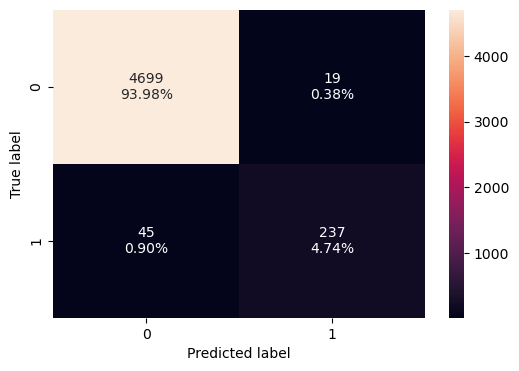

In [560]:
confusion_matrix_sklearn(tuned_rf_over, X_test,y_test)

**Observation**

- *We can see model is generalizing well on unseen testdata and giving `almost similar performance (recall=0.86 on validation; 0.84 on test set)`, suggesting small overfitting*.
- *`Accuracy,precision and f1 scores` are also `high and similar` to validation performance.*
  
- *The model in general is `giving generalized performance` on `all metrics`.*
- *Recall of 84 % means ,the `model correctly identified 84% `of `actual positive` cases.*

### Feature Importances

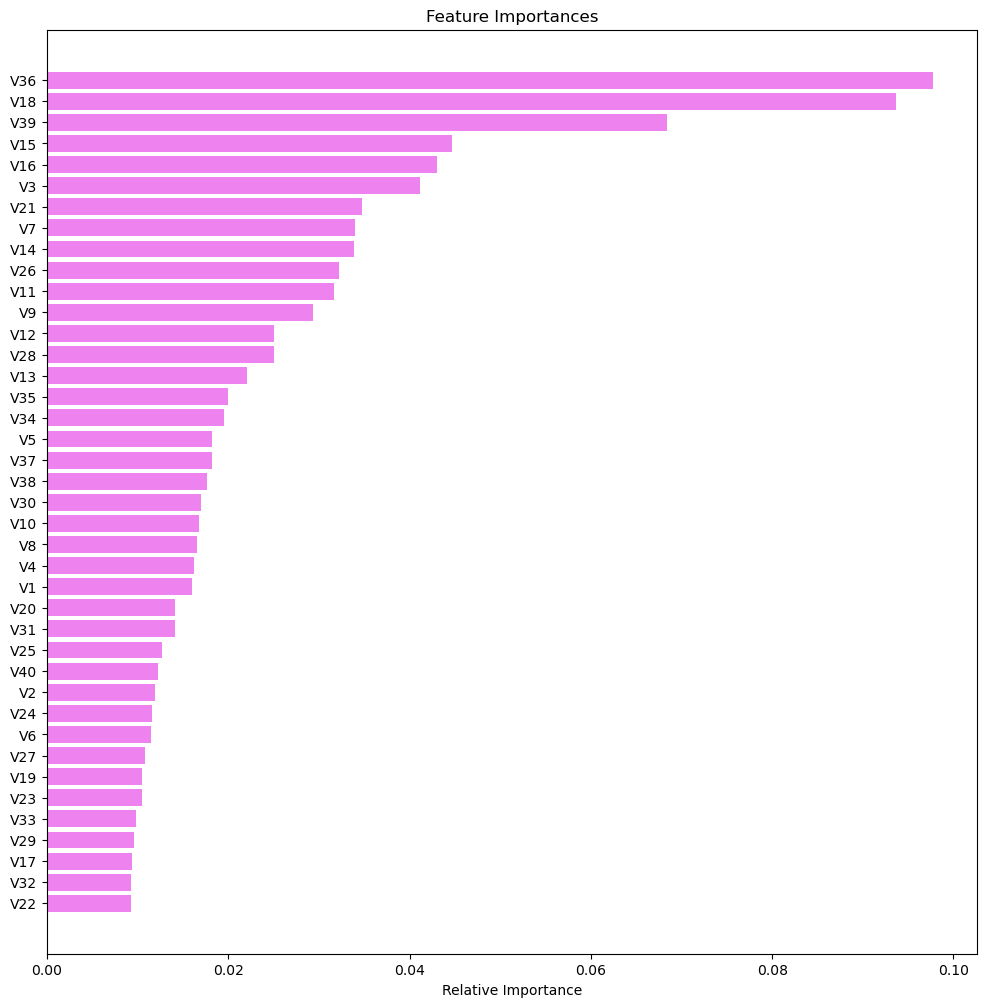

In [561]:
## Code to check the feature importance of the best model
feature_names = X_train.columns
importances =  tuned_rf_over.feature_importances_ 
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

**Observation**

- *We can see from above plot that the `V36,V18,V39 and are the top important 3 variables` in influencing or identifying the factors affecting turbine part failures.*
- *Since the data is ciphered we do not know what these variables are or indicate.*

*Lets do bivariate analyssis to check how these variables  affect the traget variable.*

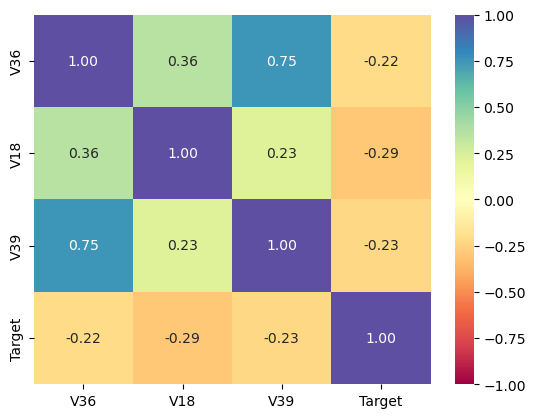

In [562]:
#lets check the correlation b/w these variables wrt target
cols_Selected=list(df[['V36','V18','V39','Target']].columns)
cols_Selected
df_corr=df[cols_Selected].corr()

#plot heat map
sns.heatmap(df_corr, cmap='Spectral', vmax=1, vmin=-1, annot=True, fmt='.2f')
plt.show()

**Observation**

- *All variable `V36,V18 and V39` are `less moderately negatively` correlated with the `target variable.`*
  
- *There is `strong positive correlation` between `V39 and V36`*

- *V36 is `moderately` related to V18.*

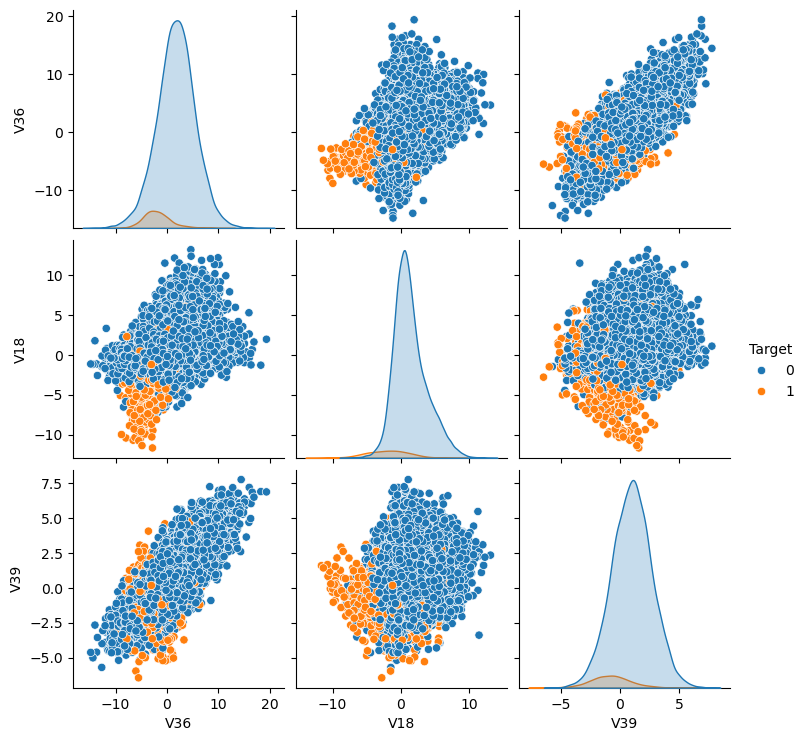

In [563]:
#pairplot
sns.pairplot(data=df[cols_Selected], hue='Target')
plt.show()

**Observation**

- *The `failure are more` and distinctly `visible`  when the value of `v18 `lies in the `range(-10 to (-1))` i.e negative and` V39 ((-4 ) to (2.5)).`*.
  
- *The `failure are more` and distinctly `visible`  when the value of `v18 `lies in the `range(-12 to (-4))` i.e negative and` V36 ((-10) to (-1)).`*
- *The `failure is less and spread out` to `different points` for `variable V39 and V36`.Few failure when `V36( -5 to 1) and V39 (-6.5 to -3)` range.*
- *We can see `class imbalanced` for all the variables(less cases of failure wrt to non-failure).*
- *The `distribution` is almost `normal` for all variables with little skewness V18.*

## Pipelines to build the final model


**`Pipelines`** are used to standardize the model building. It is a streamlined workflow that automates sequential data processing steps, such as data preprocessing, feature transformation, and model training. It ensures consistency, reduces manual coding errors, and prevents data leakage by applying the same transformations to both training and test data. <br>

Here I'm using `2 different method pipeline() and Imbpipeline() `to create pipeline for our best model.<br>
Since we have only `one datatype in the data` i.e. only numerical column no categorical, we `don't need` to use `column transformer` here.*

#### **`Method 1: using pipeline() method`**

**To prevent data leakage, here are the steps we need to follow for testing model using pipelines.**

1. `Divide` the predictor and target variable.
2. `Treat the missing value` using simpleImputer with required strategy.(you can also use any other imputer)
3. Since we are here dealing with oversample data, `apply SMOTE` before creating pipeline to avoid data leakage.
4. `Create pipeline` for Preprocessing & Model Training (Without SMOTE Inside)
5. `Fit` the Pipeline on the SMOTE-Resampled Data.
6. Check the `performance on Test` set.

**Step1: Dividing data into X1(predictors) and Y1(target)**

- *Dividing X1 and Y1 in train set for predictor and target variable.*
- *Since we already have a separate test set, we don't need to divide data into train and test.*

In [564]:
# Separating target variable and other variables
X1 = df.drop(["Target"],axis=1)
Y1 = df["Target"]

# Code to drop target variable from test data
X_test1 = df_test.drop(["Target"],axis=1)

# Code to store target variable in y_test1
y_test1 = df_test["Target"] 


**Step2: Treating missing value in train set using Simple Imputer**

In [565]:
imputer = SimpleImputer(strategy="median")
X1 = imputer.fit_transform(X1)


**Step 3: SMOTE-Synthetic Minority Over Sampling Technique**

In [566]:
# Code for oversampling on the data

sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_over1, y_over1 = sm.fit_resample(X1, Y1)

**Step 4: Create Pipeline with best model**

In [567]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),         # Handle missing values in test set
    ('Rf classifier', RandomForestClassifier(                 # Best model
        max_features='sqrt',
        random_state=1,
        max_samples=0.6,
        n_estimators=200,
        min_samples_leaf=1
    ))
])


**Step 5: Fit the model on the resampled training data**

In [568]:
%%time
pipeline.fit(X_over1, y_over1) 

CPU times: total: 48.5 s
Wall time: 1min 16s


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('Rf classifier',
                 RandomForestClassifier(max_samples=0.6, n_estimators=200,
                                        random_state=1))])

**Step 6: Check performance on Test set**

In [569]:
# Code to check the performance on test set
Pipeline_model_test = model_performance_classification_sklearn(pipeline,X_test1,y_test1)  
Pipeline_model_test

,Accuracy,Recall,Precision,F1
0,0.988,0.844,0.944,0.891


#### **`Method 2: using ImbPipeline`**

- *If we dont' want to handle it `imbalance and imputation manually` instead we can `use pipeline(ImbPipeline() method)` to automate this steps. i.e. we will `create preprocessing steps for  Imputation and SMOTE in the Pipeline` itself*.

**Step1: Divide Predictor and target variable for both train and test set**

**Step2 :Create Pipeline for best model with preprocessing steps to handle Imputation and Oversampling inside pipeline**

In [570]:
# Creating the pipeline with preprocessing steps and best model

steps = [
    ('imputer', SimpleImputer(strategy="median")),                                # Handle missing values using median imputation
    ('smote', SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)),         # Apply SMOTE to balance data
    ('Random forest classifier', RandomForestClassifier(                           # Best Model with the selected hyperparameters
        max_features='sqrt',
        random_state=1,
        max_samples=0.6,
        n_estimators=200,
        min_samples_leaf=1
    ))
]

Pipeline_model = ImbPipeline(steps) 

**Step 3: Fit the model**

In [571]:
%%time
# Fit the pipeline on training data
Pipeline_model.fit(X1, Y1)

CPU times: total: 49.1 s
Wall time: 1min 19s


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('smote', SMOTE(random_state=1, sampling_strategy=1)),
                ('Random forest classifier',
                 RandomForestClassifier(max_samples=0.6, n_estimators=200,
                                        random_state=1))])

- *`SimpleImputer(strategy="median"):` This step will handle missing values by replacing them with the median of each feature (column) for training set(X1).*
- *`SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)):` SMOTE will be applied on the imputed training data (X1). This step will balance the class distribution by applying SMOTE (Synthetic Minority Over-sampling Technique).*
  
- *`RandomForestClassifier()`: The classifier is the best model selected. After the data is imputed and balanced (via SMOTE), the RandomForestClassifier  will be trained on the transformed training data (X1) with the target variable Y1.*

**Step 4: check the performance on Test set**

In [572]:
# Code to check the performance on test set
Pipeline_model_test1 = model_performance_classification_sklearn(Pipeline_model,X_test1,y_test1)  
Pipeline_model_test1

,Accuracy,Recall,Precision,F1
0,0.988,0.844,0.944,0.891


**To make prediction on Test set,**
- *`The SimpleImputer((Imputation)` is applied to X_test1 (the test data). where it will `use the median values calculated from the training set` to impute any missing values in the test data, to avoid any data leakage.*
  
- *The trained model (RandomForestClassifier) will then `make predictions` on the imputed test data (X_test1).*

# Business Insights and Conclusions

**`Insight`**

Renewable energy sources play a crucial role in the global energy mix, with `wind energy` being one of the most developed and widely adopted technologies worldwide. The U.S. Department of Energy promotes `predictive maintenance` to enhance operational efficiency.<br>

`ReneWind `is a renewable energy company providing `machine learning solutions through predictive modeling` and analysis. Using sensor data from wind turbines, the company aims to identify failure patterns and predict component degradation before breakdowns occur, reducing operational costs.
 
The dataset consists of `40 predictors and 1 target` variable, with 20,000 training observations used for model development and 5,000 test observations for performance evaluation of the final model. All the variables present are `ciphered versions of sensor data `related to various environmental factors (temperature, humidity, wind speed, etc.) or and wind turbine components (gearbox, tower, blades, brakes). 

**`Model building Approach:`**

We have performed `Exploratory Data Analysis (EDA)` and `Data Preprocessing (handling missing values and feature scaling)`, before building multiple classification models:<br>

1. Built 7 classification model with `original data`.
2. Built another 7 classification model `with oversampled data(SMOTE method)`.
3. Using `Random Undersampler method ` built another 7 classification model.
4. Selected the best-performing model and `hyper-tuned` it by training 7 additional models.
5. `Deployed` the final model using `Pipeline`, to `standardized` the process and streamlined workflow that `automates` sequential data processing steps, such as data preprocessing, feature transformation, and model training to ensures consistency, reduces manual coding errors, and prevents data leakage.
   
***`Classification model used are:`** (`logistic regression, decision trees, random forest, bagging classifier and boosting methods(Adaboost,Xgboost and GBM)`* 

Our `goal` was to create a model which can `identify failures early`, so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost. As we know the cost of repairing a generator is much lower than the `cost of replacing(FN) `it, and the cost of inspection is even lower, so the `main focus `on building the model was to `maximized the Recall `to `minimizing` the chances of `false negatives` and avoid unexpected failures.

**Below are the conclusions and recommendation from our analysis**.


*From the `sample dataset of ReneWind` and the `final model built`, we were able to `conclude that`,*

- *The final model built can predict machine real failures early. It can `identify ~84.4% of generator failure early minimizing the replacement cost (recall)`. Also `f1 score of 0.89 means `it's relatively strong in both identifying generator replacement & inspection cost and avoiding too many false positives(i.e balance between recall and precision)*.

- *The final model is giving similar (slightly less) recall(0.844) on unseen Test data compared to validation set(~ .86), slightly overfitting*.

- *The `accuracy` of the model is overall `high(98.8)` on test sets and also on train and validation set.*
  
- *We also observed from feature importance  that the `V36,V18,V39 and are the top important 3 variables` in influencing or identifying the factors affecting turbine part failures/replacement. Since the data is ciphered we do not know what these variables are or indicates.*

- *We also observed from heatmap for important feature that there is `strong positive correlation` between `V39 and V36`*

- *All variable `V36,V18 and V39` are `less moderately negatively` correlated with the `target variable.`*
- *The `failure are more` and distinctly `visible`  when the value of `v18 `lies in the `range(-10 to (-1))` i.e negative and` V39 ((-4 ) to (2.5)).`*.
  
- *The `failure are more` and distinctly `visible`  when the value of `v18 `lies in the `range(-12 to (-4))` i.e negative and` V36 ((-10) to (-1)).`*


  

#### **Recommendations**

- *Based on above model performance the `ReneWind` can use this `finalized model to predict machine real failures early` minimizing the replacement cost (recall).*
- *The `important features identified (V36,V18,V39)` can be used for further analysis to see the failure patterns, to improve model performance further and minimizing the replacement cost.*